### Imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import os
import math

In [3]:
import pandas as pd
import numpy as np

In [4]:
from pandas.api.types import is_string_dtype, is_numeric_dtype

In [5]:
pd.__version__

'0.23.4'

In [6]:
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display

from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit

In [7]:
from category_encoders import TargetEncoder

In [8]:
import sys
sys.path.append('../src')

In [9]:
from workflow.data_utils import load_csv

In [10]:
from workflow.log_utils import get_logger

In [11]:
# from workflow.structured import add_datepart, train_cats, proc_df, apply_cats

In [12]:
from fastai.structured import add_datepart, train_cats, proc_df, apply_cats

In [13]:
import lightgbm as lgb

### Constants

In [14]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [15]:
def half_bool_columns_to_float_type(df):
    for col in df.columns:
        if is_string_dtype(df[col]):
            unqs = df[col].unique()
            if len(unqs) == 2 and (False in unqs or True in unqs):
                print(col)
                df[col] = df[col].astype(float)

In [16]:
def check_columns_and_types_same_in(a,b):
    same_names = all(a.columns == b.columns)
    same_types = [a[col].dtype == b[col].dtype for col in a.columns]
    return same_names, all(same_types)

In [17]:
# some duplicated info
drop_columns = ['date', 'sessionId', 'visitId']
LN_SPLITTER ='\n====\n'

In [18]:
logger = get_logger('new')

### Loads 

In [19]:
%%time
full_train = load_csv('../data/processed_data/processed_train.csv',
                      low_memory=False, nrows=None)

CPU times: user 5.01 s, sys: 913 ms, total: 5.92 s
Wall time: 7.03 s


In [20]:
full_train.drop(columns=drop_columns, inplace=True)

In [21]:
half_bool_columns_to_float_type(full_train)

trafficSource_adwordsClickInfo.isVideoAd
trafficSource_isTrueDirect


In [22]:
full_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 32 columns):
channelGrouping                                 903653 non-null object
fullVisitorId                                   903653 non-null object
visitNumber                                     903653 non-null int64
visitStartTime                                  903653 non-null int64
device_browser                                  903653 non-null object
device_deviceCategory                           903653 non-null object
device_isMobile                                 903653 non-null bool
device_operatingSystem                          903653 non-null object
geoNetwork_city                                 903653 non-null object
geoNetwork_continent                            903653 non-null object
geoNetwork_country                              903653 non-null object
geoNetwork_metro                                903653 non-null object
geoNetwork_networkDomain                 

In [23]:
display_all(full_train.head())

,channelGrouping,fullVisitorId,visitNumber,visitStartTime,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem,geoNetwork_city,geoNetwork_continent,geoNetwork_country,geoNetwork_metro,geoNetwork_networkDomain,geoNetwork_region,geoNetwork_subContinent,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,trafficSource_adContent,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source,totals_transactionRevenue
0,Organic Search,1131660440785968503,1,1472830385,Chrome,desktop,False,Windows,Izmir,Asia,Turkey,(not set),ttnet.com.tr,Izmir,Western Asia,1.0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,NaN
1,Organic Search,377306020877927890,1,1472880147,Firefox,desktop,False,Macintosh,not available in demo dataset,Oceania,Australia,not available in demo dataset,dodo.net.au,not available in demo dataset,Australasia,1.0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,NaN
2,Organic Search,3895546263509774583,1,1472865386,Chrome,desktop,False,Windows,Madrid,Europe,Spain,(not set),unknown.unknown,Community of Madrid,Southern Europe,1.0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,NaN
3,Organic Search,4763447161404445595,1,1472881213,UC Browser,desktop,False,Linux,not available in demo dataset,Asia,Indonesia,not available in demo dataset,unknown.unknown,not available in demo dataset,Southeast Asia,1.0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,google + online,organic,NaN,google,NaN
4,Organic Search,27294437909732085,2,1472822600,Chrome,mobile,True,Android,not available in demo dataset,Europe,United Kingdom,not available in demo dataset,unknown.unknown,not available in demo dataset,Northern Europe,1.0,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,(not set),1.0,(not provided),organic,NaN,google,NaN


In [24]:
%%time
test_df = load_csv('../data/processed_data/processed_test.csv', low_memory=False, nrows=None)

CPU times: user 4.75 s, sys: 745 ms, total: 5.5 s
Wall time: 6.48 s


In [25]:
test_df.drop(columns=drop_columns, inplace=True)

In [26]:
half_bool_columns_to_float_type(test_df)

trafficSource_adwordsClickInfo.isVideoAd
trafficSource_isTrueDirect


In [31]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804684 entries, 0 to 804683
Data columns (total 31 columns):
channelGrouping                                 804684 non-null object
fullVisitorId                                   804684 non-null object
visitNumber                                     804684 non-null int64
visitStartTime                                  804684 non-null int64
device_browser                                  804684 non-null object
device_deviceCategory                           804684 non-null object
device_isMobile                                 804684 non-null bool
device_operatingSystem                          804684 non-null object
geoNetwork_city                                 804684 non-null object
geoNetwork_continent                            804684 non-null object
geoNetwork_country                              804684 non-null object
geoNetwork_metro                                804684 non-null object
geoNetwork_networkDomain                 

#### Check column names and types are == for train and test

In [27]:
check_columns_and_types_same_in(full_train.drop('totals_transactionRevenue', axis=1), test_df)

(True, True)

In [23]:
display_all(full_train.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
channelGrouping,903653,8,Organic Search,381561,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fullVisitorId,903653,714167,1957458976293878100,278,NaN,NaN,NaN,NaN,NaN,NaN,NaN
visitNumber,903653,NaN,NaN,NaN,2.2649,9.28373,1,1,1,1,395
visitStartTime,903653,NaN,NaN,NaN,1.48501e+09,9.02212e+06,1.47003e+09,1.47756e+09,1.48395e+09,1.49276e+09,1.50166e+09
device_browser,903653,54,Chrome,620364,NaN,NaN,NaN,NaN,NaN,NaN,NaN
device_deviceCategory,903653,3,desktop,664479,NaN,NaN,NaN,NaN,NaN,NaN,NaN
device_isMobile,903653,2,False,664530,NaN,NaN,NaN,NaN,NaN,NaN,NaN
device_operatingSystem,903653,20,Windows,350072,NaN,NaN,NaN,NaN,NaN,NaN,NaN
geoNetwork_city,903653,649,not available in demo dataset,508229,NaN,NaN,NaN,NaN,NaN,NaN,NaN
geoNetwork_continent,903653,6,Americas,450377,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Workflow

In [28]:
full_train['totals_transactionRevenue'] = full_train['totals_transactionRevenue'].fillna(value=0)

In [29]:
# posix seconds to datetime
full_train['visitStartTime'] = pd.to_datetime(full_train.visitStartTime, unit='s')

In [30]:
test_df['visitStartTime'] = pd.to_datetime(test_df.visitStartTime, unit='s')

#### Take fullVisitorId -> validation ids, if it has transaction after 2017-04-30 

In [28]:
validationIds = full_train[full_train.visitStartTime > '2017-04-30'].fullVisitorId.unique()

In [29]:
validationIds.shape

(161118,)

In [30]:
# save for later use
np.save('../data/tmp/validIds.npy',validationIds)

#### Continue workflow: make time feature columns

In [31]:
# make time features
add_datepart(full_train, 'visitStartTime', time=True, drop=False)

In [32]:
# make time features
add_datepart(test_df, 'visitStartTime', time=True, drop=False)

In [33]:
set(full_train.drop('totals_transactionRevenue', axis=1).columns) - set(test_df.columns)

set()

#### Drop fullVisitorId columns to not categorize them

In [34]:
train_visitorIds = full_train.fullVisitorId
test_visitorIds = test_df.fullVisitorId

In [35]:
full_train.drop(columns=['fullVisitorId'], inplace=True)
test_df.drop(columns=['fullVisitorId'], inplace=True)

In [36]:
# make categorical data
train_cats(full_train)

In [37]:
apply_cats(test_df, full_train)

In [43]:
display_all(full_train.isnull().sum().sort_index()/len(full_train))

channelGrouping                                 0.000000
device_browser                                  0.000000
device_deviceCategory                           0.000000
device_isMobile                                 0.000000
device_operatingSystem                          0.000000
geoNetwork_city                                 0.000000
geoNetwork_continent                            0.000000
geoNetwork_country                              0.000000
geoNetwork_metro                                0.000000
geoNetwork_networkDomain                        0.000000
geoNetwork_region                               0.000000
geoNetwork_subContinent                         0.000000
totals_bounces                                  0.501324
totals_hits                                     0.000000
totals_newVisits                                0.221980
totals_pageviews                                0.000111
totals_transactionRevenue                       0.000000
trafficSource_adContent        

In [44]:
display_all(test_df.isnull().sum().sort_index()/len(test_df))

channelGrouping                                 0.000000
device_browser                                  0.019764
device_deviceCategory                           0.000000
device_isMobile                                 0.000000
device_operatingSystem                          0.001150
geoNetwork_city                                 0.009569
geoNetwork_continent                            0.000000
geoNetwork_country                              0.000034
geoNetwork_metro                                0.001099
geoNetwork_networkDomain                        0.031993
geoNetwork_region                               0.007047
geoNetwork_subContinent                         0.000000
totals_bounces                                  0.476878
totals_hits                                     0.000000
totals_newVisits                                0.248935
totals_pageviews                                0.000173
trafficSource_adContent                         0.994974
trafficSource_adwordsClickInfo.

In [38]:
# add back fullVisitosIds
full_train['fullVisitorId'] = train_visitorIds
test_df['fullVisitorId'] = test_visitorIds

In [39]:
# sort train dataframe by time
full_train.sort_values(by='visitStartTime', inplace=True)

In [40]:
full_train.reset_index(drop=True, inplace=True)

In [41]:
full_train.head()

,channelGrouping,visitNumber,visitStartTime,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem,geoNetwork_city,geoNetwork_continent,geoNetwork_country,...,visitStartTimeIs_month_start,visitStartTimeIs_quarter_end,visitStartTimeIs_quarter_start,visitStartTimeIs_year_end,visitStartTimeIs_year_start,visitStartTimeHour,visitStartTimeMinute,visitStartTimeSecond,visitStartTimeElapsed,fullVisitorId
0,Direct,3,2016-08-01 07:00:12,Safari,mobile,True,iOS,not available in demo dataset,Americas,United States,...,True,False,False,False,False,7,0,12,1470034812,0423043652415339154
1,Social,1,2016-08-01 07:04:26,Chrome,desktop,False,Windows,not available in demo dataset,Asia,Thailand,...,True,False,False,False,False,7,4,26,1470035066,8294721032567046680
2,Organic Search,1,2016-08-01 07:04:41,Amazon Silk,tablet,True,Android,not available in demo dataset,Americas,United States,...,True,False,False,False,False,7,4,41,1470035081,7718623669497357235
3,Organic Search,1,2016-08-01 07:06:01,Chrome,desktop,False,Windows,not available in demo dataset,Americas,Canada,...,True,False,False,False,False,7,6,1,1470035161,4798058133221713505
4,Direct,1,2016-08-01 07:06:10,Chrome,desktop,False,Windows,Quezon City,Asia,Philippines,...,True,False,False,False,False,7,6,10,1470035170,5076747981380011349


In [42]:
check_columns_and_types_same_in(full_train.drop(columns=['totals_transactionRevenue']), test_df)

(True, True)

In [43]:
%%time
os.makedirs('../data/tmp', exist_ok=True)
full_train.to_feather('../data/tmp/raw_train')

CPU times: user 204 ms, sys: 121 ms, total: 325 ms
Wall time: 2.71 s


In [44]:
%%time
os.makedirs('../data/tmp', exist_ok=True)
test_df.to_feather('../data/tmp/raw_test')

CPU times: user 187 ms, sys: 96.8 ms, total: 284 ms
Wall time: 1.94 s


#### Preprocess

In [19]:
%time full_train = pd.read_feather('../data/tmp/raw_train', nthreads=-1)

/home/ademyanchuk/.virtualenvs/kaggle_env/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


CPU times: user 198 ms, sys: 68.5 ms, total: 266 ms
Wall time: 360 ms


In [20]:
%time test_df = pd.read_feather('../data/tmp/raw_test', nthreads=-1)

/home/ademyanchuk/.virtualenvs/kaggle_env/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


CPU times: user 179 ms, sys: 65.3 ms, total: 244 ms
Wall time: 243 ms


##### Target Encoding 

In [42]:
trn_sample_sz = 100000

In [43]:
train_smpl_data = full_train.iloc[:trn_sample_sz].copy()

In [45]:
cat_cols = cat_feature_names(train_smpl_data, 20)

In [46]:
cat_cols

['device_browser',
 'geoNetwork_city',
 'geoNetwork_country',
 'geoNetwork_metro',
 'geoNetwork_networkDomain',
 'geoNetwork_region',
 'geoNetwork_subContinent',
 'trafficSource_adwordsClickInfo.gclId',
 'trafficSource_keyword',
 'trafficSource_referralPath',
 'trafficSource_source']

In [47]:
t_coder = TargetEncoder(cols=cat_cols, impute_missing=False)

In [ ]:
train_smpl_data = t_coder.fit_transform(train_smpl_data)

#####  TimeSeries Split way to make Validation dataset

In [18]:
tscv = TimeSeriesSplit(n_splits=5)

In [53]:
# sanity check
for i, (tr_index, val_index) in enumerate(tscv.split(full_train.visitStartTime)):
    logger.debug(f'Working with fold {i}\n===========\n')
    print(f'Train max time: {full_train.iloc[tr_index].visitStartTime.max()}, Valid max time: {full_train.iloc[val_index].visitStartTime.min()}')
    print(f'train_set length: {len(tr_index)}, valid_set length: {len(val_index)}')

2018-10-05 13:16:48,720 - new - DEBUG - Working with fold 0

Train max time: 2016-10-03 21:24:49, Valid max time: 2016-10-03 21:25:22
train_set length: 150613, valid_set length: 150608
2018-10-05 13:16:48,768 - new - DEBUG - Working with fold 1

Train max time: 2016-11-16 16:56:29, Valid max time: 2016-11-16 16:56:35
train_set length: 301221, valid_set length: 150608
2018-10-05 13:16:48,840 - new - DEBUG - Working with fold 2

Train max time: 2017-01-09 08:03:25, Valid max time: 2017-01-09 08:03:30
train_set length: 451829, valid_set length: 150608
2018-10-05 13:16:48,937 - new - DEBUG - Working with fold 3

Train max time: 2017-03-19 05:10:52, Valid max time: 2017-03-19 05:13:08
train_set length: 602437, valid_set length: 150608
2018-10-05 13:16:49,060 - new - DEBUG - Working with fold 4

Train max time: 2017-05-25 16:53:03, Valid max time: 2017-05-25 16:53:20
train_set length: 753045, valid_set length: 150608


##### Working on validation pipeline for feature selection

In [20]:
trn_sample_sz = 100000
# trn_sample_sz = len(full_train)

tst_sample_sz = 100000
# tst_sample_sz = len(test_df)

N_SPLITS = 5
tscv = TimeSeriesSplit(n_splits=N_SPLITS)

In [21]:
def rmse(x, y):
    return math.sqrt(((x-y)**2).mean())

In [22]:
def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
           m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'):
        res.append(m.oob_score_)
    print(res)
    return res

In [60]:
train_smpl_data = full_train.iloc[:trn_sample_sz].copy()
# test_smpl_data = test_df.iloc[:tst_sample_sz].copy()

In [64]:
all_features = train_smpl_data.drop(columns=[
    'visitStartTime', 'fullVisitorId', 'totals_transactionRevenue']).columns

In [65]:
stats_cols = ['col_name'] + [f'val_rmse_{i}' for i in range(N_SPLITS)] +\
             [f'val_rsq_{i}' for i in range(N_SPLITS)] +\
             ['val_mean_rmse', 'val_mean_rsq', 'val_var_rmse', 'val_var_rsq', 'rmse_delta']

In [66]:
%%time
# conduct 20 experiments to find columns that reduce rmse better
for j in range(20):
    logger.debug(f'Experiment #: {j}{LN_SPLITTER}')
    # cancel the dict
    stats_dict = {name:[] for name in stats_cols}
    # cancel columns to use
    columns_to_use = ['visitStartTime', 'fullVisitorId', 'totals_transactionRevenue']
    # cancel best rmse
    best_rmse = None
    
    # permutate features 
    feature_ids = np.random.permutation(range(len(all_features)))

    for idx in feature_ids:
        # randomly pick feature
        feature_name = all_features[idx]

        logger.debug(f'Adding feature name: {feature_name}{LN_SPLITTER}')
        # append feature name
        columns_to_use.append(feature_name)

        # create sample to train and validate model on
        full_train_smpl = train_smpl_data[columns_to_use].copy()

        # test_preds = np.zeros(len(test_smpl))

        # create array to collect metrics for every new data sample
        metrics = np.zeros((N_SPLITS, 4))

        stats_dict['col_name'].append(feature_name)

        for i, (tr_index, val_index) in enumerate(tscv.split(full_train_smpl.visitStartTime)):

            logger.debug(f'Process train split on fold {i}{LN_SPLITTER}')
            X_train, y_train, nas = proc_df(full_train_smpl.iloc[tr_index], 'totals_transactionRevenue',
                                            skip_flds=['fullVisitorId', 'visitStartTime'], max_n_cat=None)

            logger.debug(f'Process valid split on fold {i}{LN_SPLITTER}')
            X_valid, y_valid, _ = proc_df(full_train_smpl.iloc[val_index], 'totals_transactionRevenue',
                                          skip_flds=['fullVisitorId', 'visitStartTime'],
                                          max_n_cat=None, na_dict=nas)
            if i == 0:
                logger.debug(f'Number of featues: {len(X_train.columns)}{LN_SPLITTER}')
        #     if i == 0:
        #         logger.debug(f'Process test_set on fold {i}{LN_SPLITTER}')
        #         X_test, _, _ = proc_df(test_smpl, skip_flds=['fullVisitorId', 'visitStartTime'],
        #                                max_n_cat=100, na_dict=nas)

            print('Sanity check for column names and types for train and valid')
            print(f'{check_columns_and_types_same_in(X_train, X_valid)}')

        #     print('Sanity check for column names and types for train and test')
        #     print(f'{check_columns_and_types_same_in(X_train, X_test)}')

            # log(y) for training the model IMPORTANT!!!
            y_train, y_valid = np.log1p(y_train), np.log1p(y_valid)

            # train model
            m = RandomForestRegressor(n_jobs=-1, n_estimators=40)
            m.fit(X_train, y_train)

            logger.debug(f'Printing score for fold {i}{LN_SPLITTER}')
            result = print_score(m)
            metrics[i] = result

            stats_dict[f'val_rmse_{i}'].append(result[1])
            stats_dict[f'val_rsq_{i}'].append(result[3])

        #     logger.debug(f'Predicting test on iteration: {i}{LN_SPLITTER}')
        #     y_hat = m.predict(X_test)
        #     y_hat[y_hat < 0] = 0 
        #     test_preds += y_hat / N_SPLITS

        if best_rmse is None:
            best_rmse = metrics[:,1].mean()

        delta = best_rmse - metrics[:,1].mean()
        if delta > 0:
            best_rmse = metrics[:,1].mean()

        stats_dict['rmse_delta'].append(delta)
        stats_dict['val_mean_rmse'].append(metrics[:,1].mean())
        stats_dict['val_mean_rsq'].append(metrics[:,3].mean())
        stats_dict['val_var_rmse'].append(metrics[:,1].var())
        stats_dict['val_var_rsq'].append(metrics[:,3].var())


    stats_df = pd.DataFrame(stats_dict)
    
    if j == 0:
        # it's ONLY for the first time
        stats_df.to_csv('../log/feature_selection.csv', index=False, header=True)

    else:
        # this for the rest of experiments
        with open('../log/feature_selection.csv', mode='a') as fin:
            stats_df.to_csv(fin, index=False, header=False)

2018-10-07 23:52:54,488 - new - DEBUG - Experiment #: 0
====

2018-10-07 23:52:54,489 - new - DEBUG - Adding feature name: device_deviceCategory
====

2018-10-07 23:52:54,498 - new - DEBUG - Process train split on fold 0
====

2018-10-07 23:52:54,507 - new - DEBUG - Process valid split on fold 0
====

2018-10-07 23:52:54,515 - new - DEBUG - Number of featues: 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-07 23:52:54,658 - new - DEBUG - Printing score for fold 0
====

[1.6277397201538335, 2.3031455743024467, 0.0009475695970219135, -0.0026971827667565673]
2018-10-07 23:52:55,077 - new - DEBUG - Process train split on fold 1
====

2018-10-07 23:52:55,089 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-07 23:52:55,229 - new - DEBUG - Printing score for fold 1
====

[1.9925216926316611, 2.3698651792159517, 0.0015905156671955911, 0.0003849629612823202]
2018-10-07 23

[1.8289646772143293, 2.1159206623302573, 0.2830110690040737, -0.14456329921866762]
2018-10-07 23:53:09,900 - new - DEBUG - Adding feature name: trafficSource_adwordsClickInfo.isVideoAd
====

2018-10-07 23:53:09,911 - new - DEBUG - Process train split on fold 0
====

2018-10-07 23:53:09,926 - new - DEBUG - Process valid split on fold 0
====

2018-10-07 23:53:09,941 - new - DEBUG - Number of featues: 6
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-07 23:53:10,183 - new - DEBUG - Printing score for fold 0
====

[1.1888600713499744, 2.442852056090472, 0.46705813109831956, -0.12803181454330992]
2018-10-07 23:53:10,621 - new - DEBUG - Process train split on fold 1
====

2018-10-07 23:53:10,640 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-07 23:53:11,003 - new - DEBUG - Printing score for fold 1
====

[1.5671916942704718, 2.5020754437942867, 0.38234377318834467, -0.

[1.6203501224284718, 2.1363718308929442, 0.43724476007042196, -0.16679549278187245]
2018-10-07 23:53:29,813 - new - DEBUG - Adding feature name: visitStartTimeDayofweek
====

2018-10-07 23:53:29,827 - new - DEBUG - Process train split on fold 0
====

2018-10-07 23:53:29,850 - new - DEBUG - Process valid split on fold 0
====

2018-10-07 23:53:29,871 - new - DEBUG - Number of featues: 11
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-07 23:53:30,123 - new - DEBUG - Printing score for fold 0
====

[0.7786600546727672, 2.4345117998458825, 0.7713800370968681, -0.12034243025413804]
2018-10-07 23:53:30,577 - new - DEBUG - Process train split on fold 1
====

2018-10-07 23:53:30,605 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-07 23:53:30,979 - new - DEBUG - Printing score for fold 1
====

[1.0600002220878944, 2.540301006339608, 0.7174375198365148, -0.14856574938858724

[0.8786804681758089, 2.342096027602664, 0.8345130466975604, -0.4023307326619341]
2018-10-07 23:53:51,510 - new - DEBUG - Adding feature name: visitStartTimeIs_quarter_start
====

2018-10-07 23:53:51,525 - new - DEBUG - Process train split on fold 0
====

2018-10-07 23:53:51,550 - new - DEBUG - Process valid split on fold 0
====

2018-10-07 23:53:51,575 - new - DEBUG - Number of featues: 15
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-07 23:53:51,821 - new - DEBUG - Printing score for fold 0
====

[0.6855038758188146, 2.477324489524465, 0.8228104164820325, -0.1600930050314333]
2018-10-07 23:53:52,283 - new - DEBUG - Process train split on fold 1
====

2018-10-07 23:53:52,314 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-07 23:53:52,713 - new - DEBUG - Printing score for fold 1
====

[0.8180025683730828, 2.8778789734958865, 0.8317279770030367, -0.47411224271452

[0.8783028182144484, 2.285381903771777, 0.8346552661131683, -0.33523782088767407]
2018-10-07 23:54:16,301 - new - DEBUG - Adding feature name: geoNetwork_metro
====

2018-10-07 23:54:16,315 - new - DEBUG - Process train split on fold 0
====

2018-10-07 23:54:16,347 - new - DEBUG - Process valid split on fold 0
====

2018-10-07 23:54:16,378 - new - DEBUG - Number of featues: 19
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-07 23:54:16,639 - new - DEBUG - Printing score for fold 0
====

[0.6651529574826437, 2.524833000749509, 0.833174893426217, -0.20501466525980597]
2018-10-07 23:54:17,110 - new - DEBUG - Process train split on fold 1
====

2018-10-07 23:54:17,148 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-07 23:54:17,651 - new - DEBUG - Printing score for fold 1
====

[0.8152426657836062, 2.935363394057038, 0.8328615454138483, -0.5335899321588828]
2018-10-07

2018-10-07 23:54:44,159 - new - DEBUG - Process train split on fold 0
====

2018-10-07 23:54:44,194 - new - DEBUG - Process valid split on fold 0
====

2018-10-07 23:54:44,228 - new - DEBUG - Number of featues: 23
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-07 23:54:44,499 - new - DEBUG - Printing score for fold 0
====

[0.6539530370657708, 2.3698752947846353, 0.838745634701474, -0.06164178516827912]
2018-10-07 23:54:45,003 - new - DEBUG - Process train split on fold 1
====

2018-10-07 23:54:45,045 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-07 23:54:45,574 - new - DEBUG - Printing score for fold 1
====

[0.7936863892839633, 3.0137099021984013, 0.8415834879593608, -0.6165472048130243]
2018-10-07 23:54:46,101 - new - DEBUG - Process train split on fold 2
====

2018-10-07 23:54:46,151 - new - DEBUG - Process valid split on fold 2
====

Sanity check for colum

2018-10-07 23:55:13,875 - new - DEBUG - Process valid split on fold 0
====

2018-10-07 23:55:13,915 - new - DEBUG - Number of featues: 29
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-07 23:55:14,191 - new - DEBUG - Printing score for fold 0
====

[0.5819673865812648, 2.1803909874323053, 0.8722927205877515, 0.10133925203531946]
2018-10-07 23:55:14,703 - new - DEBUG - Process train split on fold 1
====

2018-10-07 23:55:14,757 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-07 23:55:15,291 - new - DEBUG - Printing score for fold 1
====

[0.6926087353996438, 2.334786538545587, 0.8793635605076086, 0.029758465461625198]
2018-10-07 23:55:15,847 - new - DEBUG - Process train split on fold 2
====

2018-10-07 23:55:15,910 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-07 23:55:16,690 -

2018-10-07 23:55:45,637 - new - DEBUG - Process valid split on fold 0
====

2018-10-07 23:55:45,682 - new - DEBUG - Number of featues: 33
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-07 23:55:45,955 - new - DEBUG - Printing score for fold 0
====

[0.5731154376562856, 2.2540664797937167, 0.8761481289373767, 0.039581631170952813]
2018-10-07 23:55:46,490 - new - DEBUG - Process train split on fold 1
====

2018-10-07 23:55:46,549 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-07 23:55:47,099 - new - DEBUG - Printing score for fold 1
====

[0.6939937242479484, 2.1950316841450395, 0.8788806120046637, 0.14243492113056722]
2018-10-07 23:55:47,676 - new - DEBUG - Process train split on fold 2
====

2018-10-07 23:55:47,744 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-07 23:55:48,733 

2018-10-07 23:56:20,202 - new - DEBUG - Process valid split on fold 0
====

2018-10-07 23:56:20,252 - new - DEBUG - Number of featues: 38
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-07 23:56:20,535 - new - DEBUG - Printing score for fold 0
====

[0.5866829822942452, 2.404553414420523, 0.870214749393956, -0.09293887596736106]
2018-10-07 23:56:21,085 - new - DEBUG - Process train split on fold 1
====

2018-10-07 23:56:21,150 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-07 23:56:21,811 - new - DEBUG - Printing score for fold 1
====

[0.6983753168448174, 2.314207117488346, 0.8773463874335803, 0.04678701304854882]
2018-10-07 23:56:22,416 - new - DEBUG - Process train split on fold 2
====

2018-10-07 23:56:22,494 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-07 23:56:23,430 - n

2018-10-07 23:56:57,604 - new - DEBUG - Process valid split on fold 0
====

2018-10-07 23:56:57,660 - new - DEBUG - Number of featues: 42
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-07 23:56:57,939 - new - DEBUG - Printing score for fold 0
====

[0.5782939232829467, 2.388807820328477, 0.87389984639009, -0.07867208733044895]
2018-10-07 23:56:58,505 - new - DEBUG - Process train split on fold 1
====

2018-10-07 23:56:58,577 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-07 23:56:59,260 - new - DEBUG - Printing score for fold 1
====

[0.687512326279029, 2.257772899157936, 0.8811323821736766, 0.09271023372825214]
2018-10-07 23:56:59,880 - new - DEBUG - Process train split on fold 2
====

2018-10-07 23:56:59,964 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-07 23:57:01,106 - new

2018-10-07 23:57:37,268 - new - DEBUG - Process valid split on fold 0
====

2018-10-07 23:57:37,330 - new - DEBUG - Number of featues: 47
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-07 23:57:37,708 - new - DEBUG - Printing score for fold 0
====

[0.5803847310365348, 2.3348569810104647, 0.8729863739135302, -0.030499020715254677]
2018-10-07 23:57:38,288 - new - DEBUG - Process train split on fold 1
====

2018-10-07 23:57:38,366 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-07 23:57:39,164 - new - DEBUG - Printing score for fold 1
====

[0.6975082430378496, 2.20019522588757, 0.8776507616361456, 0.13839554314615965]
2018-10-07 23:57:39,807 - new - DEBUG - Process train split on fold 2
====

2018-10-07 23:57:39,900 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-07 23:57:41,060 -

2018-10-07 23:58:19,311 - new - DEBUG - Process valid split on fold 0
====

2018-10-07 23:58:19,376 - new - DEBUG - Number of featues: 51
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-07 23:58:19,775 - new - DEBUG - Printing score for fold 0
====

[0.5843661394701786, 2.4211895081962456, 0.8712377833358164, -0.10811436022655464]
2018-10-07 23:58:20,362 - new - DEBUG - Process train split on fold 1
====

2018-10-07 23:58:20,445 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-07 23:58:21,256 - new - DEBUG - Printing score for fold 1
====

[0.6960113807219463, 2.1900881913826598, 0.8781753244801462, 0.1462932644907341]
2018-10-07 23:58:21,908 - new - DEBUG - Process train split on fold 2
====

2018-10-07 23:58:22,012 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-07 23:58:23,304 -

2018-10-07 23:58:40,076 - new - DEBUG - Process train split on fold 0
====

2018-10-07 23:58:40,090 - new - DEBUG - Process valid split on fold 0
====

2018-10-07 23:58:40,103 - new - DEBUG - Number of featues: 5
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-07 23:58:40,246 - new - DEBUG - Printing score for fold 0
====

[1.603344649226504, 2.2851499911928523, 0.030668933940522503, 0.012910711927091478]
2018-10-07 23:58:40,700 - new - DEBUG - Process train split on fold 1
====

2018-10-07 23:58:40,718 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-07 23:58:40,877 - new - DEBUG - Printing score for fold 1
====

[1.966390375788076, 2.356773665893094, 0.02760646828328639, 0.01139852424375054]
2018-10-07 23:58:41,338 - new - DEBUG - Process train split on fold 2
====

2018-10-07 23:58:41,359 - new - DEBUG - Process valid split on fold 2
====

Sanity check for colum

2018-10-07 23:58:55,220 - new - DEBUG - Process train split on fold 0
====

2018-10-07 23:58:55,241 - new - DEBUG - Process valid split on fold 0
====

2018-10-07 23:58:55,261 - new - DEBUG - Number of featues: 10
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-07 23:58:55,410 - new - DEBUG - Printing score for fold 0
====

[0.7383071784394646, 2.2020450126120052, 0.7944618041387779, 0.08340095395791292]
2018-10-07 23:58:55,875 - new - DEBUG - Process train split on fold 1
====

2018-10-07 23:58:55,900 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-07 23:58:56,181 - new - DEBUG - Printing score for fold 1
====

[0.9378930651304931, 2.2554882128490914, 0.7787877206580832, 0.09454551460792571]
2018-10-07 23:58:56,657 - new - DEBUG - Process train split on fold 2
====

2018-10-07 23:58:56,686 - new - DEBUG - Process valid split on fold 2
====

Sanity check for colum

2018-10-07 23:59:13,226 - new - DEBUG - Process valid split on fold 0
====

2018-10-07 23:59:13,250 - new - DEBUG - Number of featues: 14
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-07 23:59:13,399 - new - DEBUG - Printing score for fold 0
====

[0.6793501265039422, 2.1096867691826344, 0.8259773894479978, 0.15867658724136358]
2018-10-07 23:59:13,881 - new - DEBUG - Process train split on fold 1
====

2018-10-07 23:59:13,912 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-07 23:59:14,199 - new - DEBUG - Printing score for fold 1
====

[0.8077651310814017, 2.19690969620411, 0.8359135250023398, 0.1409668726010853]
2018-10-07 23:59:14,694 - new - DEBUG - Process train split on fold 2
====

2018-10-07 23:59:14,730 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-07 23:59:15,133 - ne

2018-10-07 23:59:33,487 - new - DEBUG - Number of featues: 18
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-07 23:59:33,640 - new - DEBUG - Printing score for fold 0
====

[0.6052176279162051, 2.1851572322991917, 0.8618847937843854, 0.09740608711969201]
2018-10-07 23:59:34,127 - new - DEBUG - Process train split on fold 1
====

2018-10-07 23:59:34,164 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-07 23:59:34,560 - new - DEBUG - Printing score for fold 1
====

[0.7200109712618646, 2.232625884305544, 0.8696290561898283, 0.11280841924442009]
2018-10-07 23:59:35,069 - new - DEBUG - Process train split on fold 2
====

2018-10-07 23:59:35,112 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-07 23:59:35,634 - new - DEBUG - Printing score for fold 2
====

[0.7619546863086961, 2.1537618

Sanity check for column names and types for train and valid
(True, True)
2018-10-07 23:59:56,991 - new - DEBUG - Printing score for fold 0
====

[0.6198796477410914, 2.142337957722163, 0.8551117679119695, 0.13243308496468098]
2018-10-07 23:59:57,489 - new - DEBUG - Process train split on fold 1
====

2018-10-07 23:59:57,534 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-07 23:59:57,947 - new - DEBUG - Printing score for fold 1
====

[0.7167153281788339, 2.2199927124643972, 0.8708197957832852, 0.12282024771275546]
2018-10-07 23:59:58,477 - new - DEBUG - Process train split on fold 2
====

2018-10-07 23:59:58,530 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-07 23:59:59,166 - new - DEBUG - Printing score for fold 2
====

[0.7584231426561799, 2.177171538724908, 0.8729023707042295, 0.19602241270091714]
2018-10-07 23:59:

2018-10-08 00:00:23,149 - new - DEBUG - Printing score for fold 0
====

[0.5799151703303478, 2.1413299239192334, 0.8731918117158464, 0.13324932502214681]
2018-10-08 00:00:23,640 - new - DEBUG - Process train split on fold 1
====

2018-10-08 00:00:23,695 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:00:24,132 - new - DEBUG - Printing score for fold 1
====

[0.7021781382375543, 2.1633025669745907, 0.8760069938966196, 0.1670478911994253]
2018-10-08 00:00:24,673 - new - DEBUG - Process train split on fold 2
====

2018-10-08 00:00:24,735 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:00:25,411 - new - DEBUG - Printing score for fold 2
====

[0.7435229865829645, 2.150147041056106, 0.877847292983187, 0.21585754697361714]
2018-10-08 00:00:25,997 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:0

2018-10-08 00:00:51,601 - new - DEBUG - Printing score for fold 0
====

[0.5827410890577688, 2.1115745164507427, 0.8719529313799477, 0.15717028160355695]
2018-10-08 00:00:52,127 - new - DEBUG - Process train split on fold 1
====

2018-10-08 00:00:52,186 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:00:52,625 - new - DEBUG - Printing score for fold 1
====

[0.7043487185454249, 2.1758553334139203, 0.8752392321510598, 0.1573532798467513]
2018-10-08 00:00:53,197 - new - DEBUG - Process train split on fold 2
====

2018-10-08 00:00:53,265 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:00:54,042 - new - DEBUG - Printing score for fold 2
====

[0.7478811959195201, 2.139219256028172, 0.8764110836654015, 0.2238078544155756]
2018-10-08 00:00:54,648 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:0

2018-10-08 00:01:22,028 - new - DEBUG - Printing score for fold 0
====

[0.6035703820900136, 2.124225244023238, 0.862635598371763, 0.14704101641361667]
2018-10-08 00:01:22,573 - new - DEBUG - Process train split on fold 1
====

2018-10-08 00:01:22,638 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:01:23,189 - new - DEBUG - Printing score for fold 1
====

[0.7051756111697468, 2.1206213460545045, 0.8749461264430143, 0.19959137807920635]
2018-10-08 00:01:23,789 - new - DEBUG - Process train split on fold 2
====

2018-10-08 00:01:23,867 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:01:24,671 - new - DEBUG - Printing score for fold 2
====

[0.7215674617662833, 2.1055477007677728, 0.8849548860707271, 0.2480502578175635]
2018-10-08 00:01:25,319 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:0

[0.5939995206842403, 2.115882179962946, 0.8669574540305847, 0.15372798763736484]
2018-10-08 00:01:55,510 - new - DEBUG - Process train split on fold 1
====

2018-10-08 00:01:55,581 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:01:56,170 - new - DEBUG - Printing score for fold 1
====

[0.6913807178461172, 2.117953275544456, 0.8797909658404786, 0.20160418740953223]
2018-10-08 00:01:56,779 - new - DEBUG - Process train split on fold 2
====

2018-10-08 00:01:56,865 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:01:57,798 - new - DEBUG - Printing score for fold 2
====

[0.7227316917054921, 2.0667873374195023, 0.8845833421012955, 0.2754802484858291]
2018-10-08 00:01:58,477 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:01:58,581 - new - DEBUG - Process valid split on fold 3
====

Sanity chec

[0.5894203860996553, 2.0811312032792575, 0.8690007940295992, 0.1812978365116763]
2018-10-08 00:02:31,127 - new - DEBUG - Process train split on fold 1
====

2018-10-08 00:02:31,205 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:02:31,794 - new - DEBUG - Printing score for fold 1
====

[0.6869728411073661, 2.092037829160119, 0.8813188578328708, 0.22102312083500075]
2018-10-08 00:02:32,420 - new - DEBUG - Process train split on fold 2
====

2018-10-08 00:02:32,515 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:02:33,567 - new - DEBUG - Printing score for fold 2
====

[0.7277935230529408, 2.0898762167300466, 0.8829609820260128, 0.25920204877028497]
2018-10-08 00:02:34,264 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:02:34,379 - new - DEBUG - Process valid split on fold 3
====

Sanity che

2018-10-08 00:03:11,210 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:03:12,035 - new - DEBUG - Printing score for fold 1
====

[0.6955821883817402, 2.2404848613493766, 0.8783255234510152, 0.10655149104071217]
2018-10-08 00:03:12,684 - new - DEBUG - Process train split on fold 2
====

2018-10-08 00:03:12,785 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:03:14,128 - new - DEBUG - Printing score for fold 2
====

[0.7234892428919909, 2.086185753831579, 0.8843412609795412, 0.2618160538285308]
2018-10-08 00:03:14,861 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:03:14,987 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:03:16,832 - new - DEBUG - Printing score for fold 3
====

[0.7308956495613094, 2.

2018-10-08 00:03:38,824 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:03:38,974 - new - DEBUG - Printing score for fold 1
====

[1.9749892976604917, 2.390849019808351, 0.01908342180112821, -0.01739548053614115]
2018-10-08 00:03:39,434 - new - DEBUG - Process train split on fold 2
====

2018-10-08 00:03:39,450 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:03:39,606 - new - DEBUG - Printing score for fold 2
====

[2.1097265969874166, 2.4287482175827217, 0.016517463727598103, -0.0005150714288666425]
2018-10-08 00:03:40,058 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:03:40,075 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:03:40,229 - new - DEBUG - Printing score for fold 3
====

[2.188046927636

2018-10-08 00:03:52,543 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:03:52,711 - new - DEBUG - Printing score for fold 1
====

[1.9327320776381458, 2.36882344705177, 0.060610090643507974, 0.001263580254566965]
2018-10-08 00:03:53,167 - new - DEBUG - Process train split on fold 2
====

2018-10-08 00:03:53,190 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:03:53,453 - new - DEBUG - Printing score for fold 2
====

[2.0627813603671394, 2.4535508771394148, 0.05979903338079062, -0.02105416524807624]
2018-10-08 00:03:53,914 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:03:53,940 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:03:54,323 - new - DEBUG - Printing score for fold 3
====

[2.145029478159285

2018-10-08 00:04:08,685 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:04:08,959 - new - DEBUG - Printing score for fold 1
====

[1.8085019050703501, 2.438482724595609, 0.17749125797412868, -0.058339163081613014]
2018-10-08 00:04:09,454 - new - DEBUG - Process train split on fold 2
====

2018-10-08 00:04:09,484 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:04:09,880 - new - DEBUG - Printing score for fold 2
====

[1.935984805949322, 2.5069077972660674, 0.17183249565245418, -0.0659464009466566]
2018-10-08 00:04:10,379 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:04:10,413 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:04:10,914 - new - DEBUG - Printing score for fold 3
====

[2.0063037870291964

2018-10-08 00:04:29,949 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:04:30,343 - new - DEBUG - Printing score for fold 1
====

[1.2282123089765187, 2.7001390981696747, 0.6206418031285958, -0.2976506117286508]
2018-10-08 00:04:30,845 - new - DEBUG - Process train split on fold 2
====

2018-10-08 00:04:30,881 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:04:31,394 - new - DEBUG - Printing score for fold 2
====

[1.3369980119962912, 2.8216844261626735, 0.6050193505535109, -0.35044072875126275]
2018-10-08 00:04:31,928 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:04:31,970 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:04:32,704 - new - DEBUG - Printing score for fold 3
====

[1.3619133013613234,

2018-10-08 00:04:52,580 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:04:52,995 - new - DEBUG - Printing score for fold 1
====

[1.1929516707099885, 2.6709905738381314, 0.6421110571684532, -0.26978505582974477]
2018-10-08 00:04:53,528 - new - DEBUG - Process train split on fold 2
====

2018-10-08 00:04:53,577 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:04:54,100 - new - DEBUG - Printing score for fold 2
====

[1.2968888000237637, 2.64669092251465, 0.6283622894811404, -0.18813311654354026]
2018-10-08 00:04:54,661 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:04:54,719 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:04:55,477 - new - DEBUG - Printing score for fold 3
====

[1.325888969118746, 2

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:05:20,994 - new - DEBUG - Printing score for fold 1
====

[0.7080265493835703, 2.2903600850092394, 0.8739329276135408, 0.0663307973033721]
2018-10-08 00:05:21,537 - new - DEBUG - Process train split on fold 2
====

2018-10-08 00:05:21,595 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:05:22,453 - new - DEBUG - Printing score for fold 2
====

[0.7499259385106751, 2.1980502999312224, 0.8757343639415549, 0.180528416302969]
2018-10-08 00:05:23,044 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:05:23,112 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:05:24,288 - new - DEBUG - Printing score for fold 3
====

[0.763406920170086, 1.9243041762868434, 0.8803123966625201, 0.0376370989074607]
2018-10-08 00:05:24,

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:05:52,813 - new - DEBUG - Printing score for fold 1
====

[0.719727903153374, 2.295524212718843, 0.8697315451897778, 0.06211571976639275]
2018-10-08 00:05:53,390 - new - DEBUG - Process train split on fold 2
====

2018-10-08 00:05:53,457 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:05:54,343 - new - DEBUG - Printing score for fold 2
====

[0.7485271005591275, 2.242290362643731, 0.8761975173238818, 0.147209515180301]
2018-10-08 00:05:54,968 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:05:55,050 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:05:56,389 - new - DEBUG - Printing score for fold 3
====

[0.7698100957108082, 1.944005791901883, 0.8782961854564584, 0.017830288871432898]
2018-10-08 00:05:57,

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:06:26,615 - new - DEBUG - Printing score for fold 1
====

[0.7065888676101864, 2.259687410824014, 0.8744443782638274, 0.0911708820005822]
2018-10-08 00:06:27,210 - new - DEBUG - Process train split on fold 2
====

2018-10-08 00:06:27,284 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:06:28,277 - new - DEBUG - Printing score for fold 2
====

[0.7446593109935719, 2.1949250441451937, 0.8774736362891351, 0.18285705965805932]
2018-10-08 00:06:28,912 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:06:29,004 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:06:30,458 - new - DEBUG - Printing score for fold 3
====

[0.7613702561582036, 1.9374606338231928, 0.8809501647109887, 0.02443277354721307]
2018-10-08 00:06:

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:07:02,031 - new - DEBUG - Printing score for fold 1
====

[0.703443271797705, 2.339354814065227, 0.8755597882058684, 0.02595797513264464]
2018-10-08 00:07:02,643 - new - DEBUG - Process train split on fold 2
====

2018-10-08 00:07:02,722 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:07:03,721 - new - DEBUG - Printing score for fold 2
====

[0.7515625501173259, 2.169171362948711, 0.8751913863205892, 0.20192010569138819]
2018-10-08 00:07:04,377 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:07:04,475 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:07:05,938 - new - DEBUG - Printing score for fold 3
====

[0.7696374469887349, 1.9189415391375753, 0.8783507694426684, 0.04299343712408166]
2018-10-08 00:07:0

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:07:39,858 - new - DEBUG - Printing score for fold 1
====

[0.7053660499559739, 2.2976745373670466, 0.8748785735575937, 0.060357776836974186]
2018-10-08 00:07:40,487 - new - DEBUG - Process train split on fold 2
====

2018-10-08 00:07:40,576 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:07:41,709 - new - DEBUG - Printing score for fold 2
====

[0.7475641257365464, 2.170707498276982, 0.8765158544601344, 0.20078935794774522]
2018-10-08 00:07:42,395 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:07:42,504 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:07:44,087 - new - DEBUG - Printing score for fold 3
====

[0.7583468482325614, 1.978658954132145, 0.8818937832926933, -0.01749742156131373]
2018-10-08 00:0

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:08:20,663 - new - DEBUG - Printing score for fold 1
====

[0.7022333067544202, 2.2499543456801265, 0.8759875094421842, 0.09898315073324615]
2018-10-08 00:08:21,310 - new - DEBUG - Process train split on fold 2
====

2018-10-08 00:08:21,405 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:08:22,674 - new - DEBUG - Printing score for fold 2
====

[0.7456860821324826, 2.189872088739768, 0.8771355131605407, 0.1866150323147968]
2018-10-08 00:08:23,395 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:08:23,511 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:08:25,343 - new - DEBUG - Printing score for fold 3
====

[0.7532458612743004, 1.9651722790736723, 0.8834773121697159, -0.003674028921391015]
2018-10-08 00:0

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:08:55,430 - new - DEBUG - Printing score for fold 1
====

[1.9440052291012209, 2.3630992754213267, 0.04961967044803395, 0.006084565376969442]
2018-10-08 00:08:55,870 - new - DEBUG - Process train split on fold 2
====

2018-10-08 00:08:55,884 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:08:56,034 - new - DEBUG - Printing score for fold 2
====

[2.072534364623288, 2.462404273544264, 0.05088731645157507, -0.02843620649179956]
2018-10-08 00:08:56,472 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:08:56,489 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:08:56,742 - new - DEBUG - Printing score for fold 3
====

[2.1513670628636423, 2.0611454954439763, 0.04946958832641579, -0.10410080609664574]
2018-10-08 

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:09:08,702 - new - DEBUG - Printing score for fold 1
====

[1.9376219298572068, 2.3538883100827546, 0.0558507257184766, 0.013817696641412858]
2018-10-08 00:09:09,177 - new - DEBUG - Process train split on fold 2
====

2018-10-08 00:09:09,198 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:09:09,466 - new - DEBUG - Printing score for fold 2
====

[2.067273760888176, 2.4709340433267206, 0.055699366084836166, -0.03557355419663266]
2018-10-08 00:09:09,941 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:09:09,965 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:09:10,242 - new - DEBUG - Printing score for fold 3
====

[2.1472142120029254, 1.9916369691636864, 0.053135723409620576, -0.03088871659856629]
2018-10-0

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:09:24,461 - new - DEBUG - Printing score for fold 1
====

[1.7635547365413835, 2.6342129986660217, 0.2178672547003594, -0.23505778563708857]
2018-10-08 00:09:24,950 - new - DEBUG - Process train split on fold 2
====

2018-10-08 00:09:24,976 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:09:25,368 - new - DEBUG - Printing score for fold 2
====

[1.8966893808022922, 2.571537424989403, 0.20511057018970158, -0.12161638180990963]
2018-10-08 00:09:25,875 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:09:25,906 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:09:26,407 - new - DEBUG - Printing score for fold 3
====

[1.9554414814113663, 2.2597593747279943, 0.2147162090373205, -0.32713719595039836]
2018-10-08 0

2018-10-08 00:09:43,537 - new - DEBUG - Printing score for fold 1
====

[0.8427738205273678, 2.3128077454262868, 0.8213822335841752, 0.047939456420497795]
2018-10-08 00:09:44,040 - new - DEBUG - Process train split on fold 2
====

2018-10-08 00:09:44,072 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:09:44,468 - new - DEBUG - Printing score for fold 2
====

[0.9194095127440514, 2.312166676433874, 0.8132191779955468, 0.09323046460391671]
2018-10-08 00:09:44,987 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:09:45,025 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:09:45,655 - new - DEBUG - Printing score for fold 3
====

[0.9233904154173009, 1.9647179752237613, 0.8248913054075914, -0.0032100286147758172]
2018-10-08 00:09:46,197 - new - DEBUG - Process train split on fold 4
====

2018-10-0

[0.7057260840007966, 2.249910327448017, 0.8747508116104815, 0.09901840547600604]
2018-10-08 00:10:05,074 - new - DEBUG - Process train split on fold 2
====

2018-10-08 00:10:05,119 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:10:05,641 - new - DEBUG - Printing score for fold 2
====

[0.7404857637049936, 2.1748214135664337, 0.8788432197868753, 0.19775716639276641]
2018-10-08 00:10:06,194 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:10:06,246 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:10:06,995 - new - DEBUG - Printing score for fold 3
====

[0.7505745730412914, 1.9014090653433369, 0.8843023117329949, 0.06040099498898299]
2018-10-08 00:10:07,577 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:10:07,638 - new - DEBUG - Process valid split on fold 4
====

Sanity ch

[0.7051671460167179, 2.244138718490107, 0.8749491287981889, 0.10363498379238835]
2018-10-08 00:10:28,898 - new - DEBUG - Process train split on fold 2
====

2018-10-08 00:10:28,952 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:10:29,498 - new - DEBUG - Printing score for fold 2
====

[0.7406643614157088, 2.1791928855242473, 0.8787847691478021, 0.1945288492438052]
2018-10-08 00:10:30,086 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:10:30,151 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:10:31,020 - new - DEBUG - Printing score for fold 3
====

[0.7493830086511305, 1.882330903055563, 0.8846693687062632, 0.0791617040800282]
2018-10-08 00:10:31,636 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:10:31,717 - new - DEBUG - Process valid split on fold 4
====

Sanity check

[0.7134807709183156, 2.194654254086433, 0.8719831528017965, 0.14272980799997304]
2018-10-08 00:10:55,321 - new - DEBUG - Process train split on fold 2
====

2018-10-08 00:10:55,384 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:10:56,055 - new - DEBUG - Printing score for fold 2
====

[0.747930058875122, 2.168780343477859, 0.8763949337286424, 0.20220780693672802]
2018-10-08 00:10:56,671 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:10:56,747 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:10:57,648 - new - DEBUG - Printing score for fold 3
====

[0.7522096311859089, 1.8825550409540333, 0.8837976890032498, 0.07894239402318803]
2018-10-08 00:10:58,300 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:10:58,389 - new - DEBUG - Process valid split on fold 4
====

Sanity chec

2018-10-08 00:11:24,117 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:11:24,812 - new - DEBUG - Printing score for fold 2
====

[0.7404314485915447, 2.128865390867203, 0.8788609929926211, 0.23130324336580566]
2018-10-08 00:11:25,455 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:11:25,543 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:11:26,596 - new - DEBUG - Printing score for fold 3
====

[0.7458732367694498, 1.896184310090958, 0.8857471521330521, 0.06555762343757399]
2018-10-08 00:11:27,294 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:11:27,397 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:11:28,780 - new - DEBUG - Printing score for fold 4
====

[0.7302516127017985, 1.

2018-10-08 00:11:55,438 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:11:56,257 - new - DEBUG - Printing score for fold 2
====

[0.7228107078644624, 2.1033647848525794, 0.8845581037462455, 0.24960860976575053]
2018-10-08 00:11:56,927 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:11:57,024 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:11:58,275 - new - DEBUG - Printing score for fold 3
====

[0.7388200418866303, 1.8680576797867414, 0.8878977519867486, 0.09307371004086473]
2018-10-08 00:11:59,008 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:11:59,120 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:12:00,728 - new - DEBUG - Printing score for fold 4
====

[0.7273266432257858, 

2018-10-08 00:12:29,866 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:12:30,797 - new - DEBUG - Printing score for fold 2
====

[0.7291384846964526, 2.1430617956519398, 0.8825280063687798, 0.22101690370254237]
2018-10-08 00:12:31,493 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:12:31,603 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:12:32,983 - new - DEBUG - Printing score for fold 3
====

[0.7278632769207277, 1.8239369774360157, 0.8911980691960145, 0.135408256268446]
2018-10-08 00:12:33,759 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:12:33,884 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:12:35,734 - new - DEBUG - Printing score for fold 4
====

[0.7244219377521134, 1.

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:13:08,544 - new - DEBUG - Printing score for fold 2
====

[0.7322757727316692, 2.093852694675118, 0.8815149303622478, 0.25638028430783266]
2018-10-08 00:13:09,262 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:13:09,383 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:13:11,096 - new - DEBUG - Printing score for fold 3
====

[0.7347579317455218, 1.8462922615720068, 0.8891270630831087, 0.11408444585010102]
2018-10-08 00:13:11,894 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:13:12,034 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:13:14,104 - new - DEBUG - Printing score for fold 4
====

[0.7238578750990172, 1.7694353036167758, 0.8876925873223508, 0.19959382042330687]
2018-10-08 00:13

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:13:47,698 - new - DEBUG - Printing score for fold 2
====

[2.126204300659438, 2.4284695630088806, 0.0010947835849819398, -0.00028550287554085507]
2018-10-08 00:13:48,138 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:13:48,153 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:13:48,299 - new - DEBUG - Printing score for fold 3
====

[2.205548108724498, 1.961898181375834, 0.0009894919968465032, -0.00033244974496215995]
2018-10-08 00:13:48,742 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:13:48,759 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:13:48,902 - new - DEBUG - Printing score for fold 4
====

[2.1589489923322267, 1.981286916227472, 0.0009514853844937443, -0.003542570607723894]


Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:14:06,492 - new - DEBUG - Printing score for fold 2
====

[0.840817889253325, 2.466359059065806, 0.8437866367082094, -0.03174233359373946]
2018-10-08 00:14:06,963 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:14:06,991 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:14:07,467 - new - DEBUG - Printing score for fold 3
====

[0.8517442589966859, 1.9561993520603584, 0.8510105847383692, 0.0054705469109394]
2018-10-08 00:14:07,948 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:14:07,979 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:14:08,661 - new - DEBUG - Printing score for fold 4
====

[0.8413960492238878, 2.0221929236972946, 0.8482590663717283, -0.0454089877354511]
2018-10-08 00:14:

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:14:24,762 - new - DEBUG - Printing score for fold 2
====

[0.7967082558594288, 2.3948850681983456, 0.8597467506523011, 0.02719006385519729]
2018-10-08 00:14:25,246 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:14:25,279 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:14:25,871 - new - DEBUG - Printing score for fold 3
====

[0.8103487395633132, 1.8938930744067863, 0.8651406979774217, 0.06781450760404384]
2018-10-08 00:14:26,374 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:14:26,412 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:14:27,118 - new - DEBUG - Printing score for fold 4
====

[0.8075457661086921, 1.9300392708062584, 0.8602228748399592, 0.04770095583224332]
2018-10-08 00:1

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:14:45,367 - new - DEBUG - Printing score for fold 2
====

[0.759924452669773, 2.2468449219657534, 0.8723986893385948, 0.14374160610813758]
2018-10-08 00:14:45,873 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:14:45,912 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:14:46,641 - new - DEBUG - Printing score for fold 3
====

[0.7880707923377905, 1.9066671743837935, 0.8724538219269865, 0.055197122450727054]
2018-10-08 00:14:47,167 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:14:47,210 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:14:48,149 - new - DEBUG - Printing score for fold 4
====

[0.778445848281808, 1.914858910199649, 0.8701151107371115, 0.06262230140779901]
2018-10-08 00:14:

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:15:09,099 - new - DEBUG - Printing score for fold 2
====

[0.7676294047114688, 2.235171202087707, 0.8697980461674156, 0.15261605367272468]
2018-10-08 00:15:09,644 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:15:09,695 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:15:10,523 - new - DEBUG - Printing score for fold 3
====

[0.7911500722625837, 1.9160196518688453, 0.8714551357710495, 0.0459056013151532]
2018-10-08 00:15:11,088 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:15:11,150 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:15:12,228 - new - DEBUG - Printing score for fold 4
====

[0.7760414311957937, 1.8931477238966201, 0.8709162329854667, 0.08375827741434883]
2018-10-08 00:15:

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:15:35,521 - new - DEBUG - Printing score for fold 2
====

[0.7599878128629678, 2.2204807453305806, 0.8723774104319565, 0.16371815541744206]
2018-10-08 00:15:36,091 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:15:36,149 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:15:37,227 - new - DEBUG - Printing score for fold 3
====

[0.7845593391476431, 1.8969184700819224, 0.8735879196058034, 0.06483389314318344]
2018-10-08 00:15:37,840 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:15:37,909 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:15:39,199 - new - DEBUG - Printing score for fold 4
====

[0.7669054604546435, 1.845079830776632, 0.873937627892738, 0.1296951979504004]
2018-10-08 00:15:3

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:16:04,174 - new - DEBUG - Printing score for fold 2
====

[0.7504807579350063, 2.179246941751774, 0.8755504244643754, 0.194488888327901]
2018-10-08 00:16:04,763 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:16:04,831 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:16:05,945 - new - DEBUG - Printing score for fold 3
====

[0.7710726341892065, 1.9007975036809708, 0.8778966537995415, 0.06100531557443434]
2018-10-08 00:16:06,582 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:16:06,661 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:16:08,107 - new - DEBUG - Printing score for fold 4
====

[0.7619103777951699, 1.79981334423782, 0.87557444316147, 0.17187481655444947]
2018-10-08 00:16:08,77

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:16:35,090 - new - DEBUG - Printing score for fold 2
====

[0.7558579937189641, 2.2101089894584094, 0.8737606594046659, 0.17151237197385472]
2018-10-08 00:16:35,704 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:16:35,782 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:16:37,010 - new - DEBUG - Printing score for fold 3
====

[0.7745886327710175, 2.0003402516290114, 0.8767805617847382, -0.03991819287110454]
2018-10-08 00:16:37,673 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:16:37,766 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:16:39,321 - new - DEBUG - Printing score for fold 4
====

[0.7633434640279172, 1.803967362490934, 0.8751059359648172, 0.16804773415150132]
2018-10-08 00:1

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:17:08,025 - new - DEBUG - Printing score for fold 2
====

[0.7315284614866664, 2.0795500478892017, 0.8817566426967528, 0.2665045924771847]
2018-10-08 00:17:08,673 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:17:08,764 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:17:10,107 - new - DEBUG - Printing score for fold 3
====

[0.7336111052163569, 2.0144648014782627, 0.8894728988722252, -0.054655919811302356]
2018-10-08 00:17:10,809 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:17:10,915 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:17:12,608 - new - DEBUG - Printing score for fold 4
====

[0.7230749058575832, 1.7635502463769692, 0.8879354131469407, 0.20490919175053401]
2018-10-08 00:

2018-10-08 00:17:43,195 - new - DEBUG - Printing score for fold 2
====

[0.721210168373999, 2.090342627772686, 0.8850687899935055, 0.25887135463864397]
2018-10-08 00:17:43,866 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:17:43,971 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:17:45,468 - new - DEBUG - Printing score for fold 3
====

[0.725849564699296, 2.1633887442798097, 0.8917992609546007, -0.21635560165694145]
2018-10-08 00:17:46,202 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:17:46,325 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:17:48,258 - new - DEBUG - Printing score for fold 4
====

[0.7254739926090414, 1.7789157935698168, 0.8871905423847882, 0.1909938209534775]
2018-10-08 00:17:49,070 - new - DEBUG - Adding feature name: visitStartTimeIs_quarter_end
=

2018-10-08 00:18:21,692 - new - DEBUG - Printing score for fold 2
====

[0.7194478133561062, 2.1136668202047537, 0.8856297973880829, 0.24223994944286498]
2018-10-08 00:18:22,398 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:18:22,511 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:18:24,202 - new - DEBUG - Printing score for fold 3
====

[0.732990596946396, 2.1772530274850594, 0.8896597934683947, -0.23199581938100566]
2018-10-08 00:18:24,997 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:18:25,130 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:18:27,189 - new - DEBUG - Printing score for fold 4
====

[0.7237878626738461, 1.7555274842394475, 0.8877143112942556, 0.21212680875501644]
2018-10-08 00:18:28,045 - new - DEBUG - Adding feature name: trafficSource_keyword
====


2018-10-08 00:19:03,924 - new - DEBUG - Printing score for fold 2
====

[0.7275540768971737, 2.101221436737649, 0.883037981702332, 0.25113714206938875]
2018-10-08 00:19:04,670 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:19:04,796 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:19:06,732 - new - DEBUG - Printing score for fold 3
====

[0.7302685380551845, 2.065625072568624, 0.8904777980697514, -0.10890520180779006]
2018-10-08 00:19:07,563 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:19:07,709 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:19:10,000 - new - DEBUG - Printing score for fold 4
====

[0.7180859893179855, 1.7660187452561456, 0.8894764766064428, 0.20268180482211517]
2018-10-08 00:19:10,912 - new - DEBUG - Experiment #: 5
====

2018-10-08 00:19:10,913 - ne

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:19:21,865 - new - DEBUG - Printing score for fold 2
====

[2.035294380612166, 2.4530326083936473, 0.08468882725151683, -0.02062285194085356]
2018-10-08 00:19:22,308 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:19:22,328 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:19:22,587 - new - DEBUG - Printing score for fold 3
====

[2.09806033519929, 1.9831151921662742, 0.09599062915270618, -0.022085697436639018]
2018-10-08 00:19:23,031 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:19:23,054 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:19:23,410 - new - DEBUG - Printing score for fold 4
====

[2.0547413427672407, 1.9939342540252845, 0.09506760897651899, -0.016395480765028614]
2018-10-08

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:19:37,313 - new - DEBUG - Printing score for fold 2
====

[1.5786759200253209, 2.7845099845747447, 0.4493187801591053, -0.3150922073020055]
2018-10-08 00:19:37,757 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:19:37,784 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:19:38,258 - new - DEBUG - Printing score for fold 3
====

[1.6209194542239325, 2.4303359522230674, 0.4604150162410417, -0.5350553899244912]
2018-10-08 00:19:38,709 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:19:38,740 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:19:39,317 - new - DEBUG - Printing score for fold 4
====

[1.5829900564851227, 2.1743787653002915, 0.4628962449536093, -0.20868032645815604]
2018-10-08 00:

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:19:54,870 - new - DEBUG - Printing score for fold 2
====

[1.5798131883723818, 2.765581175714209, 0.4485250796990581, -0.2972732598288659]
2018-10-08 00:19:55,325 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:19:55,365 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:19:55,963 - new - DEBUG - Printing score for fold 3
====

[1.6185929847158758, 2.259904651228254, 0.46196281324763033, -0.32730784070737307]
2018-10-08 00:19:56,421 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:19:56,468 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:19:57,276 - new - DEBUG - Printing score for fold 4
====

[1.5835545844412537, 2.070552574011672, 0.4625130913773628, -0.09600763987975403]
2018-10-08 00:1

2018-10-08 00:20:16,776 - new - DEBUG - Printing score for fold 2
====

[0.8733076972860229, 2.8275567550809746, 0.8314810002845319, -0.35606749838150703]
2018-10-08 00:20:17,228 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:20:17,275 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:20:18,287 - new - DEBUG - Printing score for fold 3
====

[0.8835282184978349, 2.365281108456456, 0.8396836430942143, -0.4539750496493624]
2018-10-08 00:20:18,747 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:20:18,802 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:20:20,007 - new - DEBUG - Printing score for fold 4
====

[0.8836767602825741, 2.261690308891464, 0.8326257352226107, -0.3076976135218754]
2018-10-08 00:20:20,477 - new - DEBUG - Adding feature name: geoNetwork_region
====

2018

2018-10-08 00:20:42,920 - new - DEBUG - Printing score for fold 2
====

[0.856590505116645, 2.768028798838442, 0.8378709608616383, -0.2995705282273795]
2018-10-08 00:20:43,480 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:20:43,544 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:20:44,630 - new - DEBUG - Printing score for fold 3
====

[0.8888695457790843, 2.318122291793958, 0.8377394143091474, -0.39657452079139066]
2018-10-08 00:20:45,221 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:20:45,288 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:20:46,596 - new - DEBUG - Printing score for fold 4
====

[0.8706218574387103, 2.130141183023404, 0.8375345763913229, -0.15999958715943285]
2018-10-08 00:20:47,217 - new - DEBUG - Adding feature name: visitStartTimeDayofweek
====


2018-10-08 00:21:11,846 - new - DEBUG - Printing score for fold 2
====

[0.8567773288991591, 2.712976460920437, 0.8378002319351152, -0.24839119410569133]
2018-10-08 00:21:12,427 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:21:12,492 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:21:13,565 - new - DEBUG - Printing score for fold 3
====

[0.8871885751976629, 2.2408891105878674, 0.8383525467178563, -0.3050650529223753]
2018-10-08 00:21:14,189 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:21:14,265 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:21:15,695 - new - DEBUG - Printing score for fold 4
====

[0.8744909397684526, 2.086861267184817, 0.8360873606111392, -0.11334102859935657]
2018-10-08 00:21:16,353 - new - DEBUG - Adding feature name: visitStartTimeIs_year_start

2018-10-08 00:21:42,506 - new - DEBUG - Printing score for fold 2
====

[0.8483163805142833, 2.648803631849719, 0.8409879624105532, -0.19003071763876586]
2018-10-08 00:21:43,122 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:21:43,197 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:21:44,510 - new - DEBUG - Printing score for fold 3
====

[0.8659041262178462, 2.233810754962162, 0.8460156429404688, -0.29683338736677767]
2018-10-08 00:21:45,164 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:21:45,251 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:21:46,904 - new - DEBUG - Printing score for fold 4
====

[0.8528787114412957, 2.0546833827575623, 0.8440891413539954, -0.07927191045805215]
2018-10-08 00:21:47,610 - new - DEBUG - Adding feature name: geoNetwork_city
====

2018

2018-10-08 00:22:18,185 - new - DEBUG - Printing score for fold 2
====

[0.827661461939246, 3.293382937208069, 0.8486369869899179, -0.8396834760528988]
2018-10-08 00:22:18,817 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:22:18,902 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:22:20,766 - new - DEBUG - Printing score for fold 3
====

[0.8537853841934079, 2.413535979795601, 0.850295650819823, -0.513906252993817]
2018-10-08 00:22:21,452 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:22:21,550 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:22:23,865 - new - DEBUG - Printing score for fold 4
====

[0.8308981553321645, 2.111955097119064, 0.8520219143981204, -0.1402771393121629]
2018-10-08 00:22:24,613 - new - DEBUG - Adding feature name: trafficSource_isTrueDirect
====



2018-10-08 00:22:57,730 - new - DEBUG - Printing score for fold 2
====

[0.7300952890868947, 2.1036836484243477, 0.8822195012823255, 0.24938107851000257]
2018-10-08 00:22:58,407 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:22:58,513 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:23:00,100 - new - DEBUG - Printing score for fold 3
====

[0.7345010163718045, 2.084767545570293, 0.8892045851642415, -0.12955323326087553]
2018-10-08 00:23:00,829 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:23:00,949 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:23:03,100 - new - DEBUG - Printing score for fold 4
====

[0.7214476997969026, 1.8012998619277334, 0.8884392253826786, 0.17050630675073297]
2018-10-08 00:23:03,918 - new - DEBUG - Adding feature name: trafficSource_source
====



2018-10-08 00:23:38,193 - new - DEBUG - Printing score for fold 2
====

[0.7250273439060155, 2.107101722145149, 0.8838489691503197, 0.24693987955124141]
2018-10-08 00:23:38,905 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:23:39,019 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:23:40,735 - new - DEBUG - Printing score for fold 3
====

[0.7388377903243204, 2.1676501738801637, 0.8878923659291181, -0.22115226051648573]
2018-10-08 00:23:41,528 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:23:41,660 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:23:43,851 - new - DEBUG - Printing score for fold 4
====

[0.7219754528921344, 1.7763149979310515, 0.888275947909346, 0.1933576446598677]
2018-10-08 00:23:44,708 - new - DEBUG - Adding feature name: trafficSource_adContent
====


2018-10-08 00:24:20,627 - new - DEBUG - Printing score for fold 2
====

[0.7276126807942438, 2.0808889675956337, 0.8830191385500262, 0.26555976538169723]
2018-10-08 00:24:21,354 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:24:21,476 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:24:23,307 - new - DEBUG - Printing score for fold 3
====

[0.7386058712832371, 2.1796688139815457, 0.8879627354058461, -0.23473127546262518]
2018-10-08 00:24:24,129 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:24:24,275 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:24:26,667 - new - DEBUG - Printing score for fold 4
====

[0.7217780646628915, 1.786641378593754, 0.8883370303133771, 0.18395175905704375]
2018-10-08 00:24:27,564 - new - DEBUG - Adding feature name: device_browser
====

2018-1

[2.057893163059647, 2.3735056190182044, 0.06424976427931217, 0.044481337678154875]
2018-10-08 00:24:46,396 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:24:46,414 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:24:46,675 - new - DEBUG - Printing score for fold 3
====

[2.1362062558830406, 1.9300179707161358, 0.06281926858618281, 0.03191356777232435]
2018-10-08 00:24:47,099 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:24:47,119 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:24:47,374 - new - DEBUG - Printing score for fold 4
====

[2.0915479440132305, 1.9380203799758957, 0.06235711289064716, 0.03980876693997526]
2018-10-08 00:24:47,818 - new - DEBUG - Adding feature name: trafficSource_adwordsClickInfo.adNetworkType
====

2018-10-08 00:24:47,827 - new - DEBUG - Proce

[2.040687397539697, 2.3544280731615137, 0.0798317130612415, 0.05977996722928047]
2018-10-08 00:24:59,961 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:24:59,986 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:25:00,278 - new - DEBUG - Printing score for fold 3
====

[2.113101713771851, 1.939763910086377, 0.08298214831597439, 0.022111862941599836]
2018-10-08 00:25:00,764 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:25:00,792 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:25:01,175 - new - DEBUG - Printing score for fold 4
====

[2.0727158581009077, 1.9446003049722413, 0.07916598123384999, 0.03327765745683653]
2018-10-08 00:25:01,680 - new - DEBUG - Adding feature name: visitStartTimeDayofyear
====

2018-10-08 00:25:01,690 - new - DEBUG - Process train split on fold 0

[1.6999864527208681, 2.72460368440178, 0.361434843394432, -0.2591147874472066]
2018-10-08 00:25:17,963 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:25:18,000 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:25:18,617 - new - DEBUG - Printing score for fold 3
====

[1.7407743079040237, 2.6271739402486625, 0.3776683015215594, -0.7937796097737908]
2018-10-08 00:25:19,154 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:25:19,197 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:25:20,026 - new - DEBUG - Printing score for fold 4
====

[1.711675759203718, 2.214025922263402, 0.37202144177820384, -0.2531598142439293]
2018-10-08 00:25:20,566 - new - DEBUG - Adding feature name: trafficSource_keyword
====

2018-10-08 00:25:20,578 - new - DEBUG - Process train split on fold 0
====


[1.6473840057492781, 2.7006481924818395, 0.4003415099403176, -0.23707113045557102]
2018-10-08 00:25:40,157 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:25:40,201 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:25:41,043 - new - DEBUG - Printing score for fold 3
====

[1.6857799050637878, 2.495528859361195, 0.416368490316651, -0.6185145989482095]
2018-10-08 00:25:41,608 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:25:41,661 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:25:42,712 - new - DEBUG - Printing score for fold 4
====

[1.6561106173360036, 2.2319701157570817, 0.4121310830908719, -0.2735553008733651]
2018-10-08 00:25:43,297 - new - DEBUG - Adding feature name: visitStartTimeDayofweek
====

2018-10-08 00:25:43,311 - new - DEBUG - Process train split on fold 0


[1.4248094679727743, 2.757991447710308, 0.5514324206520065, -0.2901626814826843]
2018-10-08 00:26:05,141 - new - DEBUG - Process train split on fold 3
====

2018-10-08 00:26:05,193 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:26:06,156 - new - DEBUG - Printing score for fold 3
====

[1.4620152038605045, 2.365428568803719, 0.5610240132960529, -0.4541563476340498]
2018-10-08 00:26:06,740 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:26:06,802 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:26:08,086 - new - DEBUG - Printing score for fold 4
====

[1.431342972521973, 2.129651787044382, 0.5608739157514029, -0.1594666328893246]
2018-10-08 00:26:08,703 - new - DEBUG - Adding feature name: device_isMobile
====

2018-10-08 00:26:08,719 - new - DEBUG - Process train split on fold 0
====

2018-

2018-10-08 00:26:32,664 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:26:33,670 - new - DEBUG - Printing score for fold 3
====

[1.3381461182912215, 2.276306559593556, 0.6322572978075722, -0.34664439454707185]
2018-10-08 00:26:34,301 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:26:34,380 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:26:35,616 - new - DEBUG - Printing score for fold 4
====

[1.3181225208481024, 2.0271520185507788, 0.6275968246061941, -0.050542661252964916]
2018-10-08 00:26:36,293 - new - DEBUG - Adding feature name: visitStartTimeMinute
====

2018-10-08 00:26:36,311 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:26:36,350 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:26:36,389 - new - DEBUG - Number of featues: 27
====

Sanity c

2018-10-08 00:27:02,867 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:27:03,988 - new - DEBUG - Printing score for fold 3
====

[0.742970848525146, 1.8730501970644777, 0.8866345976748584, 0.08821958191006385]
2018-10-08 00:27:04,654 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:27:04,748 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:27:06,218 - new - DEBUG - Printing score for fold 4
====

[0.7352264224070927, 1.7768666077742234, 0.8841371979331701, 0.19285658381149307]
2018-10-08 00:27:06,940 - new - DEBUG - Adding feature name: visitStartTimeHour
====

2018-10-08 00:27:06,959 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:27:07,004 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:27:07,048 - new - DEBUG - Number of featues: 32
====

Sanity check 

2018-10-08 00:27:34,994 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:27:36,352 - new - DEBUG - Printing score for fold 3
====

[0.74259234969048, 1.8893030936854545, 0.8867500739228603, 0.0723274641354642]
2018-10-08 00:27:37,063 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:27:37,171 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:27:38,876 - new - DEBUG - Printing score for fold 4
====

[0.7380560255193229, 1.7502565538581638, 0.8832436592591963, 0.21685084799425558]
2018-10-08 00:27:39,644 - new - DEBUG - Adding feature name: totals_hits
====

2018-10-08 00:27:39,665 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:27:39,716 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:27:39,765 - new - DEBUG - Number of featues: 37
====

Sanity check for colum

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:28:12,140 - new - DEBUG - Printing score for fold 3
====

[0.739382516115148, 1.851388043415725, 0.887726996933873, 0.10918742881191323]
2018-10-08 00:28:12,873 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:28:12,990 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:28:14,815 - new - DEBUG - Printing score for fold 4
====

[0.7254387560096324, 1.7561069635448014, 0.8872015005312519, 0.21160658726531645]
2018-10-08 00:28:15,623 - new - DEBUG - Adding feature name: visitStartTimeMonth
====

2018-10-08 00:28:15,646 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:28:15,702 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:28:15,756 - new - DEBUG - Number of featues: 41
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:28:

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:28:49,711 - new - DEBUG - Printing score for fold 3
====

[0.7306981092366258, 1.8275122596323254, 0.8903489100873293, 0.13201538781640632]
2018-10-08 00:28:50,467 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:28:50,592 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:28:52,634 - new - DEBUG - Printing score for fold 4
====

[0.718380952476346, 1.7836262367545062, 0.8893856600091805, 0.18670376631337626]
2018-10-08 00:28:53,476 - new - DEBUG - Adding feature name: visitStartTimeIs_year_end
====

2018-10-08 00:28:53,499 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:28:53,559 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:28:53,617 - new - DEBUG - Number of featues: 45
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-0

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:29:29,570 - new - DEBUG - Printing score for fold 3
====

[0.7353844227170272, 1.9860644138680859, 0.8889379109723029, -0.025127980362945612]
2018-10-08 00:29:30,371 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:29:30,508 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:29:32,779 - new - DEBUG - Printing score for fold 4
====

[0.7214297783934362, 1.7814007005971768, 0.8884447678518583, 0.1887320959069818]
2018-10-08 00:29:33,658 - new - DEBUG - Adding feature name: totals_newVisits
====

2018-10-08 00:29:33,684 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:29:33,751 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:29:33,814 - new - DEBUG - Number of featues: 50
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:29

2018-10-08 00:30:00,636 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:30:00,894 - new - DEBUG - Printing score for fold 3
====

[2.1767444986229054, 1.9397471766171854, 0.026912493283567044, 0.022128734469469058]
2018-10-08 00:30:01,343 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:30:01,361 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:30:01,619 - new - DEBUG - Printing score for fold 4
====

[2.1305057715187146, 1.9632814150027265, 0.027102146934980254, 0.014614498898009365]
2018-10-08 00:30:02,086 - new - DEBUG - Adding feature name: visitStartTimeHour
====

2018-10-08 00:30:02,095 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:30:02,106 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:30:02,116 - new - DEBUG - Number of featues: 3
====

Sanity 

2018-10-08 00:30:14,885 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:30:15,165 - new - DEBUG - Printing score for fold 3
====

[2.1207095879128124, 1.9474326500038444, 0.07636711854688516, 0.01436453502122026]
2018-10-08 00:30:15,661 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:30:15,692 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:30:16,078 - new - DEBUG - Printing score for fold 4
====

[2.072383655670299, 1.9643204154504539, 0.07946112905534786, 0.013571258862185243]
2018-10-08 00:30:16,576 - new - DEBUG - Adding feature name: trafficSource_keyword
====

2018-10-08 00:30:16,586 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:30:16,604 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:30:16,621 - new - DEBUG - Number of featues: 8
====

Sanity c

2018-10-08 00:30:31,420 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:30:31,821 - new - DEBUG - Printing score for fold 3
====

[2.0920521792461084, 1.964601990001466, 0.10116078777693614, -0.003091585046673062]
2018-10-08 00:30:32,345 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:30:32,385 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:30:32,901 - new - DEBUG - Printing score for fold 4
====

[2.0284963715441173, 2.0544095599723393, 0.1180371638919061, -0.07898426560651584]
2018-10-08 00:30:33,436 - new - DEBUG - Adding feature name: visitStartTimeMinute
====

2018-10-08 00:30:33,448 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:30:33,470 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:30:33,491 - new - DEBUG - Number of featues: 12
====

Sanity 

2018-10-08 00:30:51,255 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:30:51,992 - new - DEBUG - Printing score for fold 3
====

[1.4364438983022905, 2.263025032200574, 0.576245499705266, -0.3309757525149115]
2018-10-08 00:30:52,528 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:30:52,578 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:30:53,421 - new - DEBUG - Printing score for fold 4
====

[1.3853423665619122, 2.233636003548884, 0.5886456947663681, -0.2754571112678077]
2018-10-08 00:30:53,992 - new - DEBUG - Adding feature name: trafficSource_medium
====

2018-10-08 00:30:54,006 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:30:54,032 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:30:54,057 - new - DEBUG - Number of featues: 16
====

Sanity check 

2018-10-08 00:31:14,135 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:31:14,892 - new - DEBUG - Printing score for fold 3
====

[1.2308423796373011, 2.2067465029556463, 0.688870014936912, -0.26559957975106774]
2018-10-08 00:31:15,476 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:31:15,542 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:31:16,517 - new - DEBUG - Printing score for fold 4
====

[1.1836654877174277, 2.1651485376090895, 0.6996969210369144, -0.19844042219193447]
2018-10-08 00:31:17,141 - new - DEBUG - Adding feature name: geoNetwork_subContinent
====

2018-10-08 00:31:17,157 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:31:17,191 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:31:17,223 - new - DEBUG - Number of featues: 22
====

Sanity

2018-10-08 00:31:38,967 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:31:39,838 - new - DEBUG - Printing score for fold 3
====

[0.7834753897069753, 1.8244230776979191, 0.8739369808951624, 0.13494734749498116]
2018-10-08 00:31:40,457 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:31:40,532 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:31:41,534 - new - DEBUG - Printing score for fold 4
====

[0.7618799333011925, 1.8494685112451894, 0.875584386581442, 0.12555008497002773]
2018-10-08 00:31:42,178 - new - DEBUG - Adding feature name: device_isMobile
====

2018-10-08 00:31:42,195 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:31:42,233 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:31:42,268 - new - DEBUG - Number of featues: 26
====

Sanity check for

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:32:06,240 - new - DEBUG - Printing score for fold 3
====

[0.7719690302340906, 1.8408409175065312, 0.8776125908643853, 0.11930821343544296]
2018-10-08 00:32:06,879 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:32:06,963 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:32:08,209 - new - DEBUG - Printing score for fold 4
====

[0.7615757737126583, 1.852795927139536, 0.8756837057691573, 0.12240077375883496]
2018-10-08 00:32:08,887 - new - DEBUG - Adding feature name: device_browser
====

2018-10-08 00:32:08,904 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:32:08,946 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:32:08,986 - new - DEBUG - Number of featues: 30
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:32:09,

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:32:35,220 - new - DEBUG - Printing score for fold 3
====

[0.7587911120771058, 1.9832681022224117, 0.8817553619583979, -0.022243321368247804]
2018-10-08 00:32:35,884 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:32:35,976 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:32:37,548 - new - DEBUG - Printing score for fold 4
====

[0.7481080934748587, 1.8011036339640265, 0.880041639536399, 0.1706870217954125]
2018-10-08 00:32:38,273 - new - DEBUG - Adding feature name: trafficSource_adContent
====

2018-10-08 00:32:38,292 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:32:38,338 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:32:38,383 - new - DEBUG - Number of featues: 34
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:33:08,502 - new - DEBUG - Printing score for fold 3
====

[0.7589140153030639, 1.9523566789547153, 0.8817170541179917, 0.009373930310880185]
2018-10-08 00:33:09,197 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:33:09,302 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:33:11,004 - new - DEBUG - Printing score for fold 4
====

[0.7474619757265487, 1.823627517509184, 0.8802487586843843, 0.1498152109431572]
2018-10-08 00:33:11,781 - new - DEBUG - Adding feature name: totals_pageviews
====

2018-10-08 00:33:11,801 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:33:11,853 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:33:11,904 - new - DEBUG - Number of featues: 40
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:33:1

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:33:44,352 - new - DEBUG - Printing score for fold 3
====

[0.7341815675425868, 2.1116166356717345, 0.8893009383839342, -0.1588349301998946]
2018-10-08 00:33:45,117 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:33:45,238 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:33:47,083 - new - DEBUG - Printing score for fold 4
====

[0.7207674836674628, 1.7912726385261144, 0.888649496103841, 0.17971562092424953]
2018-10-08 00:33:47,919 - new - DEBUG - Adding feature name: geoNetwork_networkDomain
====

2018-10-08 00:33:47,944 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:33:48,004 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:33:48,062 - new - DEBUG - Number of featues: 45
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:34:23,041 - new - DEBUG - Printing score for fold 3
====

[0.7352346465834511, 2.175578834504499, 0.8889831465138619, -0.2301018679551301]
2018-10-08 00:34:23,831 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:34:23,972 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:34:26,145 - new - DEBUG - Printing score for fold 4
====

[0.7180305122921056, 1.7790153887728122, 0.8894935533343228, 0.19090323162887823]
2018-10-08 00:34:27,021 - new - DEBUG - Adding feature name: visitStartTimeDayofyear
====

2018-10-08 00:34:27,045 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:34:27,108 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:34:27,170 - new - DEBUG - Number of featues: 49
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 

2018-10-08 00:35:01,087 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:35:01,235 - new - DEBUG - Printing score for fold 3
====

[2.2062569378401626, 1.961684986964203, 0.000347255699404303, -0.0001150544666657094]
2018-10-08 00:35:01,662 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:35:01,677 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:35:01,825 - new - DEBUG - Printing score for fold 4
====

[2.159536257061989, 1.9780532656406942, 0.00040790074751739786, -0.00026948801342152606]
2018-10-08 00:35:02,267 - new - DEBUG - Adding feature name: trafficSource_isTrueDirect
====

2018-10-08 00:35:02,275 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:35:02,286 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:35:02,296 - new - DEBUG - Number of featues: 3


2018-10-08 00:35:14,127 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:35:14,403 - new - DEBUG - Printing score for fold 3
====

[2.137970763295641, 1.9515109428471245, 0.06127040568408815, 0.010231997672591753]
2018-10-08 00:35:14,883 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:35:14,910 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:35:15,299 - new - DEBUG - Printing score for fold 4
====

[2.0937373345169394, 1.9560050971555563, 0.06039307387492887, 0.021905039478793076]
2018-10-08 00:35:15,791 - new - DEBUG - Adding feature name: trafficSource_adwordsClickInfo.gclId
====

2018-10-08 00:35:15,801 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:35:15,817 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:35:15,833 - new - DEBUG - Number of featues: 

2018-10-08 00:35:32,035 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:35:32,965 - new - DEBUG - Printing score for fold 3
====

[1.0465071068799359, 2.203276285727526, 0.7750834828925004, -0.26162227450446895]
2018-10-08 00:35:33,485 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:35:33,522 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:35:34,679 - new - DEBUG - Printing score for fold 4
====

[1.0189296008747595, 2.0249012899895535, 0.7774691775043866, -0.048211140264978525]
2018-10-08 00:35:35,206 - new - DEBUG - Adding feature name: visitStartTimeYear
====

2018-10-08 00:35:35,219 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:35:35,240 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:35:35,261 - new - DEBUG - Number of featues: 11
====

Sanity che

2018-10-08 00:35:56,106 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:35:57,039 - new - DEBUG - Printing score for fold 3
====

[0.9565693789826764, 2.311339939680922, 0.8120813280346696, -0.38841429255028603]
2018-10-08 00:35:57,597 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:35:57,642 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:35:58,695 - new - DEBUG - Printing score for fold 4
====

[0.9351741215742155, 2.463039037277211, 0.8125494255288068, -0.5508994686018862]
2018-10-08 00:35:59,264 - new - DEBUG - Adding feature name: geoNetwork_networkDomain
====

2018-10-08 00:35:59,278 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:35:59,304 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:35:59,330 - new - DEBUG - Number of featues: 15
====

Sanity 

2018-10-08 00:36:23,711 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:36:24,873 - new - DEBUG - Printing score for fold 3
====

[0.9265335012673209, 2.3214277382736013, 0.8236971878159431, -0.40056015483508234]
2018-10-08 00:36:25,457 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:36:25,511 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:36:27,016 - new - DEBUG - Printing score for fold 4
====

[0.9122247868699573, 2.3242516288826542, 0.821636678070259, -0.3810434578179407]
2018-10-08 00:36:27,634 - new - DEBUG - Adding feature name: visitStartTimeDayofweek
====

2018-10-08 00:36:27,648 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:36:27,677 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:36:27,708 - new - DEBUG - Number of featues: 19
====

Sanity 

2018-10-08 00:36:54,222 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:36:55,499 - new - DEBUG - Printing score for fold 3
====

[0.8892024211494927, 2.630839372301994, 0.8376178606650141, -0.7987884627319757]
2018-10-08 00:36:56,109 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:36:56,174 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:36:57,915 - new - DEBUG - Printing score for fold 4
====

[0.8681690058596807, 2.5045034229831176, 0.838448732644704, -0.6035566829581458]
2018-10-08 00:36:58,550 - new - DEBUG - Adding feature name: trafficSource_adwordsClickInfo.page
====

2018-10-08 00:36:58,567 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:36:58,603 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:36:58,639 - new - DEBUG - Number of featues: 24
===

2018-10-08 00:37:25,535 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:37:26,761 - new - DEBUG - Printing score for fold 3
====

[0.7402291184811091, 2.154088413341227, 0.8874697417107035, -0.20591994266885671]
2018-10-08 00:37:27,413 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:37:27,501 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:37:29,055 - new - DEBUG - Printing score for fold 4
====

[0.7231995066999612, 1.807878328943178, 0.8878967877019236, 0.16443651092285805]
2018-10-08 00:37:29,771 - new - DEBUG - Adding feature name: trafficSource_medium
====

2018-10-08 00:37:29,793 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:37:29,837 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:37:29,879 - new - DEBUG - Number of featues: 30
====

Sanity chec

2018-10-08 00:37:58,464 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:37:59,814 - new - DEBUG - Printing score for fold 3
====

[0.7339600892195881, 2.0836140089652213, 0.8893677168092087, -0.12830357785045177]
2018-10-08 00:38:00,520 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:38:00,624 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:38:02,320 - new - DEBUG - Printing score for fold 4
====

[0.724469598783854, 1.7870066609476307, 0.8875026877966974, 0.18361803960081435]
2018-10-08 00:38:03,083 - new - DEBUG - Adding feature name: visitStartTimeIs_quarter_end
====

2018-10-08 00:38:03,106 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:38:03,156 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:38:03,204 - new - DEBUG - Number of featues: 35
====

Sa

2018-10-08 00:38:34,099 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:38:35,576 - new - DEBUG - Printing score for fold 3
====

[0.7357702055153131, 2.128629664288689, 0.8888213540243091, -0.17758332733213456]
2018-10-08 00:38:36,309 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:38:36,428 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:38:38,345 - new - DEBUG - Printing score for fold 4
====

[0.7249845019381358, 1.7890218657488732, 0.88734272026837, 0.1817757359161325]
2018-10-08 00:38:39,151 - new - DEBUG - Adding feature name: visitStartTimeWeek
====

2018-10-08 00:38:39,175 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:38:39,232 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:38:39,287 - new - DEBUG - Number of featues: 40
====

Sanity check fo

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:39:13,552 - new - DEBUG - Printing score for fold 3
====

[0.7323568622556691, 2.3811271022053218, 0.8898505085694907, -0.4735218642950427]
2018-10-08 00:39:14,321 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:39:14,449 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:39:16,424 - new - DEBUG - Printing score for fold 4
====

[0.7201953607555119, 1.7650994053727456, 0.8888261991099695, 0.20351171178346927]
2018-10-08 00:39:17,250 - new - DEBUG - Adding feature name: geoNetwork_subContinent
====

2018-10-08 00:39:17,274 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:39:17,335 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:39:17,393 - new - DEBUG - Number of featues: 44
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:39:54,265 - new - DEBUG - Printing score for fold 3
====

[0.732418269305481, 2.108706042001104, 0.8898320360481571, -0.15564252017427593]
2018-10-08 00:39:55,055 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:39:55,194 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:39:57,463 - new - DEBUG - Printing score for fold 4
====

[0.7241824238921521, 1.7565089904537536, 0.8875918564808825, 0.2112455709334442]
2018-10-08 00:39:58,338 - new - DEBUG - Adding feature name: visitStartTimeMonth
====

2018-10-08 00:39:58,363 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:39:58,427 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:39:58,490 - new - DEBUG - Number of featues: 48
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:39

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:40:37,875 - new - DEBUG - Printing score for fold 3
====

[0.7319867653408686, 2.0427748866003803, 0.8899618086432377, -0.08450722112722309]
2018-10-08 00:40:38,704 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:40:38,854 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:40:41,273 - new - DEBUG - Printing score for fold 4
====

[0.7304714875306995, 1.7792654199310074, 0.8856309924353546, 0.19067578714535371]
2018-10-08 00:40:42,183 - new - DEBUG - Experiment #: 9
====

2018-10-08 00:40:42,184 - new - DEBUG - Adding feature name: trafficSource_referralPath
====

2018-10-08 00:40:42,194 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:40:42,203 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:40:42,212 - new - DEBUG - Number of featues: 1
====

Sanity check for c

2018-10-08 00:40:53,900 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:40:54,154 - new - DEBUG - Printing score for fold 3
====

[2.081989758749118, 2.2590779362405344, 0.10978652564498816, -0.32633691073709015]
2018-10-08 00:40:54,591 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:40:54,613 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:40:54,981 - new - DEBUG - Printing score for fold 4
====

[2.039689939673364, 1.9746814753143629, 0.10827668343964338, 0.003137725017670401]
2018-10-08 00:40:55,422 - new - DEBUG - Adding feature name: geoNetwork_country
====

2018-10-08 00:40:55,432 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:40:55,446 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:40:55,459 - new - DEBUG - Number of featues: 5
====

Sanity chec

2018-10-08 00:41:08,983 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:41:09,356 - new - DEBUG - Printing score for fold 3
====

[2.041562527165742, 2.2244263807371447, 0.14402248433966724, -0.28596012391098524]
2018-10-08 00:41:09,805 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:41:09,835 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:41:10,311 - new - DEBUG - Printing score for fold 4
====

[2.0007994145468753, 2.0247928776760067, 0.14195726556458954, -0.048098901754120904]
2018-10-08 00:41:10,763 - new - DEBUG - Adding feature name: geoNetwork_networkDomain
====

2018-10-08 00:41:10,774 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:41:10,792 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:41:10,810 - new - DEBUG - Number of featues: 9
====

San

2018-10-08 00:41:27,843 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:41:28,570 - new - DEBUG - Printing score for fold 3
====

[1.7656495000660128, 2.7516003796408297, 0.35975532170606184, -0.9677147870155758]
2018-10-08 00:41:29,094 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:41:29,135 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:41:30,062 - new - DEBUG - Printing score for fold 4
====

[1.7350247517110913, 2.1548750660356295, 0.35477206100059466, -0.18709437984360378]
2018-10-08 00:41:30,620 - new - DEBUG - Adding feature name: visitStartTimeYear
====

2018-10-08 00:41:30,633 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:41:30,657 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:41:30,683 - new - DEBUG - Number of featues: 14
====

Sanity ch

2018-10-08 00:41:50,605 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:41:51,556 - new - DEBUG - Printing score for fold 3
====

[1.050973699692619, 2.6997458237766683, 0.7731594550876613, -0.8942495116503155]
2018-10-08 00:41:52,116 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:41:52,174 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:41:53,362 - new - DEBUG - Printing score for fold 4
====

[1.0319346476325166, 2.2688130874060586, 0.7717524084591889, -0.3159472907556107]
2018-10-08 00:41:53,958 - new - DEBUG - Adding feature name: device_operatingSystem
====

2018-10-08 00:41:53,974 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:41:54,005 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:41:54,035 - new - DEBUG - Number of featues: 19
====

Sanity ch

2018-10-08 00:42:17,736 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:42:18,717 - new - DEBUG - Printing score for fold 3
====

[0.9489285921662155, 2.659325771093509, 0.8150714132056196, -0.8379534696297999]
2018-10-08 00:42:19,324 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:42:19,393 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:42:20,602 - new - DEBUG - Printing score for fold 4
====

[0.9299849419282205, 2.29804120990677, 0.8146239396522469, -0.3500712277751161]
2018-10-08 00:42:21,240 - new - DEBUG - Adding feature name: visitStartTimeMinute
====

2018-10-08 00:42:21,258 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:42:21,294 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:42:21,331 - new - DEBUG - Number of featues: 24
====

Sanity check 

2018-10-08 00:42:46,959 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:42:48,164 - new - DEBUG - Printing score for fold 3
====

[0.8697264461621249, 2.5052801871202743, 0.8446531906176163, -0.631188066390884]
2018-10-08 00:42:48,805 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:42:48,886 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:42:50,414 - new - DEBUG - Printing score for fold 4
====

[0.844462235051999, 2.1189916690978703, 0.8471511133370948, -0.1478881047981213]
2018-10-08 00:42:51,103 - new - DEBUG - Adding feature name: visitStartTimeElapsed
====

2018-10-08 00:42:51,121 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:42:51,162 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:42:51,203 - new - DEBUG - Number of featues: 28
====

Sanity chec

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:43:23,913 - new - DEBUG - Printing score for fold 3
====

[0.7628863251575937, 1.9631975480036858, 0.8804755796843088, -0.0016579303872199525]
2018-10-08 00:43:24,574 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:43:24,671 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:43:26,574 - new - DEBUG - Printing score for fold 4
====

[0.7488253741287894, 1.834090892484397, 0.8798114988359256, 0.14003106066644755]
2018-10-08 00:43:27,302 - new - DEBUG - Adding feature name: visitStartTimeWeek
====

2018-10-08 00:43:27,321 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:43:27,367 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:43:27,412 - new - DEBUG - Number of featues: 32
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:43:59,996 - new - DEBUG - Printing score for fold 3
====

[0.7621615746305485, 1.9815357452661384, 0.8807025708787267, -0.020458270821806623]
2018-10-08 00:44:00,696 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:44:00,802 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:44:02,810 - new - DEBUG - Printing score for fold 4
====

[0.755314816721925, 1.8224753884707927, 0.877719326160704, 0.15088912889330086]
2018-10-08 00:44:03,576 - new - DEBUG - Adding feature name: channelGrouping
====

2018-10-08 00:44:03,597 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:44:03,647 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:44:03,695 - new - DEBUG - Number of featues: 36
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:44:0

2018-10-08 00:44:38,965 - new - DEBUG - Printing score for fold 3
====

[0.7569365682917257, 1.9430064838416845, 0.882332653585872, 0.018839789817834296]
2018-10-08 00:44:39,705 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:44:39,821 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:44:41,968 - new - DEBUG - Printing score for fold 4
====

[0.7464248740090722, 1.8408222465668278, 0.8805808372715964, 0.1337070794503913]
2018-10-08 00:44:42,755 - new - DEBUG - Adding feature name: device_browser
====

2018-10-08 00:44:42,777 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:44:42,832 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:44:42,886 - new - DEBUG - Number of featues: 40
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:44:43,272 - new - DEBUG - Printing score for fold 0
====

[0.6052898346625213, 

2018-10-08 00:45:20,265 - new - DEBUG - Printing score for fold 3
====

[0.758855034744881, 1.9792545025657249, 0.8817354386067178, -0.01811001848043059]
2018-10-08 00:45:21,031 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:45:21,158 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:45:23,523 - new - DEBUG - Printing score for fold 4
====

[0.7419090361963677, 1.8154313458491225, 0.8820214277087162, 0.15744023438383403]
2018-10-08 00:45:24,369 - new - DEBUG - Adding feature name: trafficSource_adwordsClickInfo.page
====

2018-10-08 00:45:24,394 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:45:24,455 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:45:24,515 - new - DEBUG - Number of featues: 46
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:45:24,900 - new - DEBUG - Printing score for fold 0
====


2018-10-08 00:46:03,597 - new - DEBUG - Printing score for fold 3
====

[0.7375524301319166, 2.15606592817746, 0.8882820951696643, -0.2081350970570237]
2018-10-08 00:46:04,411 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:46:04,557 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:46:07,034 - new - DEBUG - Printing score for fold 4
====

[0.7198614266330546, 1.7602483755861364, 0.8889292714728945, 0.20788367969244181]
2018-10-08 00:46:07,943 - new - DEBUG - Adding feature name: visitStartTimeMonth
====

2018-10-08 00:46:07,970 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:46:08,038 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:46:08,103 - new - DEBUG - Number of featues: 51
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:46:08,498 - new - DEBUG - Printing score for fold 0
====

[0.57596855788564

2018-10-08 00:46:27,014 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:46:27,171 - new - DEBUG - Printing score for fold 3
====

[2.206607193524891, 1.9623928939929285, 2.982952540431238e-05, -0.0008370013909404506]
2018-10-08 00:46:27,622 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:46:27,640 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:46:27,792 - new - DEBUG - Printing score for fold 4
====

[2.159949866166925, 1.9782293034978224, 2.496669435492205e-05, -0.00044753492012516993]
2018-10-08 00:46:28,256 - new - DEBUG - Adding feature name: geoNetwork_country
====

2018-10-08 00:46:28,264 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:46:28,275 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:46:28,286 - new - DEBUG - Number of featues: 4
====

Sa

2018-10-08 00:46:41,220 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:46:41,701 - new - DEBUG - Printing score for fold 3
====

[1.9900517486036657, 2.064760590335749, 0.18667199711337246, -0.10797722290170642]
2018-10-08 00:46:42,179 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:46:42,208 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:46:42,804 - new - DEBUG - Printing score for fold 4
====

[1.964222581435971, 2.056471527274906, 0.17304245487670855, -0.08115125978967619]
2018-10-08 00:46:43,294 - new - DEBUG - Adding feature name: totals_pageviews
====

2018-10-08 00:46:43,305 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:46:43,323 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:46:43,340 - new - DEBUG - Number of featues: 9
====

Sanity check f

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:46:59,748 - new - DEBUG - Printing score for fold 3
====

[0.7817004799776115, 1.9508431597209182, 0.874507508154552, 0.010909254737100915]
2018-10-08 00:47:00,286 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:47:00,333 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:47:00,958 - new - DEBUG - Printing score for fold 4
====

[0.77858869069822, 1.8434117772519838, 0.8700674394091843, 0.13126809333771317]
2018-10-08 00:47:01,503 - new - DEBUG - Adding feature name: trafficSource_keyword
====

2018-10-08 00:47:01,517 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:47:01,541 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:47:01,565 - new - DEBUG - Number of featues: 14
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:47:20,005 - new - DEBUG - Printing score for fold 3
====

[0.7809357135134362, 1.8909693510235854, 0.8747529359239585, 0.07069043426649813]
2018-10-08 00:47:20,575 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:47:20,635 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:47:21,396 - new - DEBUG - Printing score for fold 4
====

[0.7764904638294106, 1.8033543008989175, 0.8707668090224243, 0.1686131006047369]
2018-10-08 00:47:21,995 - new - DEBUG - Adding feature name: trafficSource_adwordsClickInfo.adNetworkType
====

2018-10-08 00:47:22,011 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:47:22,041 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:47:22,069 - new - DEBUG - Number of featues: 19
====

Sanity check for column names and types for train and valid
(Tr

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:47:42,032 - new - DEBUG - Printing score for fold 3
====

[0.7475663766800373, 1.834816329557519, 0.8852278531172336, 0.12506332548420085]
2018-10-08 00:47:42,622 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:47:42,695 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:47:43,570 - new - DEBUG - Printing score for fold 4
====

[0.7305289467773503, 1.7874591251178324, 0.8856129990828748, 0.18320457684468294]
2018-10-08 00:47:44,199 - new - DEBUG - Adding feature name: geoNetwork_metro
====

2018-10-08 00:47:44,217 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:47:44,252 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:47:44,285 - new - DEBUG - Number of featues: 23
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:47:4

2018-10-08 00:48:06,780 - new - DEBUG - Printing score for fold 3
====

[0.7382139383980575, 1.8751603596319981, 0.8880816064833845, 0.08616401639993898]
2018-10-08 00:48:07,406 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:48:07,484 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:48:08,600 - new - DEBUG - Printing score for fold 4
====

[0.7209286020673087, 1.780280182744817, 0.8885997085631585, 0.1897523652622768]
2018-10-08 00:48:09,264 - new - DEBUG - Adding feature name: geoNetwork_city
====

2018-10-08 00:48:09,282 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:48:09,321 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:48:09,358 - new - DEBUG - Number of featues: 27
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:48:09,617 - new - DEBUG - Printing score for fold 0
====

[0.6017699909982663, 

[0.7337489232581716, 1.8357326347058067, 0.8894313671686928, 0.12418922255342357]
2018-10-08 00:48:34,830 - new - DEBUG - Process train split on fold 4
====

2018-10-08 00:48:34,916 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:48:36,145 - new - DEBUG - Printing score for fold 4
====

[0.7254822702689181, 1.7481107672333451, 0.887187968057775, 0.218769927636152]
2018-10-08 00:48:36,847 - new - DEBUG - Adding feature name: geoNetwork_region
====

2018-10-08 00:48:36,865 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:48:36,907 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:48:36,948 - new - DEBUG - Number of featues: 31
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:48:37,221 - new - DEBUG - Printing score for fold 0
====

[0.5818711184207568, 2.1290952793076845, 0.8723349673813573, 0.14312551634558068]
2018-10-08

2018-10-08 00:49:04,939 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:49:06,410 - new - DEBUG - Printing score for fold 4
====

[0.7145324142997715, 1.779068959702734, 0.8905676602034408, 0.19085450274305182]
2018-10-08 00:49:07,148 - new - DEBUG - Adding feature name: visitStartTimeSecond
====

2018-10-08 00:49:07,168 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:49:07,215 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:49:07,260 - new - DEBUG - Number of featues: 35
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:49:07,533 - new - DEBUG - Printing score for fold 0
====

[0.5927968002210469, 2.105639098107176, 0.8674956733089115, 0.16190183723673168]
2018-10-08 00:49:08,076 - new - DEBUG - Process train split on fold 1
====

2018-10-08 00:49:08,134 - new - DEBUG - Process valid split on fold 1
====

Sanity check

2018-10-08 00:49:38,823 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:49:40,537 - new - DEBUG - Printing score for fold 4
====

[0.7209542493883818, 1.760664235598059, 0.8885917822030295, 0.20750935931970493]
2018-10-08 00:49:41,325 - new - DEBUG - Adding feature name: visitStartTimeElapsed
====

2018-10-08 00:49:41,346 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:49:41,399 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:49:41,452 - new - DEBUG - Number of featues: 40
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:49:41,731 - new - DEBUG - Printing score for fold 0
====

[0.5797697061205161, 2.1997521565838825, 0.8732554201205782, 0.0853087582818588]
2018-10-08 00:49:42,262 - new - DEBUG - Process train split on fold 1
====

2018-10-08 00:49:42,327 - new - DEBUG - Process valid split on fold 1
====

Sanity chec

2018-10-08 00:50:17,414 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:50:19,570 - new - DEBUG - Printing score for fold 4
====

[0.7213465503386199, 1.761706192483778, 0.8884705056012492, 0.20657109363676218]
2018-10-08 00:50:20,424 - new - DEBUG - Adding feature name: visitStartTimeDayofweek
====

2018-10-08 00:50:20,448 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:50:20,507 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:50:20,565 - new - DEBUG - Number of featues: 45
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:50:20,949 - new - DEBUG - Printing score for fold 0
====

[0.5742886788102697, 2.290769320078793, 0.8756405284269504, 0.00805011256850674]
2018-10-08 00:50:21,515 - new - DEBUG - Process train split on fold 1
====

2018-10-08 00:50:21,590 - new - DEBUG - Process valid split on fold 1
====

Sanity ch

2018-10-08 00:50:59,466 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:51:01,876 - new - DEBUG - Printing score for fold 4
====

[0.7205488808413484, 1.7670759809901262, 0.8887170292378939, 0.20172688222165236]
2018-10-08 00:51:02,747 - new - DEBUG - Adding feature name: device_deviceCategory
====

2018-10-08 00:51:02,773 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:51:02,837 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:51:02,900 - new - DEBUG - Number of featues: 49
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:51:03,286 - new - DEBUG - Printing score for fold 0
====

[0.5751414004627469, 2.3019953785125176, 0.8752709486433394, -0.0016959346378480065]
2018-10-08 00:51:03,864 - new - DEBUG - Process train split on fold 1
====

2018-10-08 00:51:03,944 - new - DEBUG - Process valid split on fold 1
====

Sanity

2018-10-08 00:51:30,134 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:51:30,283 - new - DEBUG - Printing score for fold 4
====

[2.1573082323893567, 1.9781610489450359, 0.002469423890426037, -0.0003784995247375633]
2018-10-08 00:51:30,724 - new - DEBUG - Adding feature name: totals_hits
====

2018-10-08 00:51:30,733 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:51:30,744 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:51:30,753 - new - DEBUG - Number of featues: 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:51:30,892 - new - DEBUG - Printing score for fold 0
====

[1.207585500970009, 2.277728803301534, 0.45013745475264694, 0.019311587371572125]
2018-10-08 00:51:31,341 - new - DEBUG - Process train split on fold 1
====

2018-10-08 00:51:31,354 - new - DEBUG - Process valid split on fold 1
====

Sanity check fo

2018-10-08 00:51:44,150 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:51:44,628 - new - DEBUG - Printing score for fold 4
====

[1.0911927765285654, 1.9466279134409017, 0.7447858322967195, 0.031260629786519445]
2018-10-08 00:51:45,072 - new - DEBUG - Adding feature name: trafficSource_keyword
====

2018-10-08 00:51:45,084 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:51:45,099 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:51:45,112 - new - DEBUG - Number of featues: 7
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:51:45,253 - new - DEBUG - Printing score for fold 0
====

[0.8400274304581952, 2.2822074269589065, 0.733924250731093, 0.015451204718483156]
2018-10-08 00:51:45,696 - new - DEBUG - Process train split on fold 1
====

2018-10-08 00:51:45,714 - new - DEBUG - Process valid split on fold 1
====

Sanity ch

2018-10-08 00:52:00,486 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:52:01,102 - new - DEBUG - Printing score for fold 4
====

[0.9206173814211455, 1.924262081149561, 0.8183396463473618, 0.05339345989558697]
2018-10-08 00:52:01,621 - new - DEBUG - Adding feature name: visitStartTimeYear
====

2018-10-08 00:52:01,633 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:52:01,652 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:52:01,670 - new - DEBUG - Number of featues: 11
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:52:01,821 - new - DEBUG - Printing score for fold 0
====

[0.721853722697074, 2.251560553183594, 0.8035207194699653, 0.041715907280714726]
2018-10-08 00:52:02,294 - new - DEBUG - Process train split on fold 1
====

2018-10-08 00:52:02,318 - new - DEBUG - Process valid split on fold 1
====

Sanity check f

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:52:20,276 - new - DEBUG - Printing score for fold 4
====

[0.8062796414657966, 1.9022543814199482, 0.8606608352212315, 0.07492223370925066]
2018-10-08 00:52:20,836 - new - DEBUG - Adding feature name: visitStartTimeIs_month_start
====

2018-10-08 00:52:20,851 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:52:20,875 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:52:20,896 - new - DEBUG - Number of featues: 15
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:52:21,041 - new - DEBUG - Printing score for fold 0
====

[0.6438793748494172, 2.2011712018935885, 0.8436753786022899, 0.08412825531086154]
2018-10-08 00:52:21,528 - new - DEBUG - Process train split on fold 1
====

2018-10-08 00:52:21,557 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:52:42,096 - new - DEBUG - Printing score for fold 4
====

[0.775847216619114, 1.8530113330149078, 0.870980834722222, 0.12219670269448013]
2018-10-08 00:52:42,697 - new - DEBUG - Adding feature name: device_deviceCategory
====

2018-10-08 00:52:42,712 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:52:42,742 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:52:42,770 - new - DEBUG - Number of featues: 20
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:52:42,928 - new - DEBUG - Printing score for fold 0
====

[0.5992056345796614, 2.1905672286024096, 0.864615129081883, 0.09293128380175951]
2018-10-08 00:52:43,428 - new - DEBUG - Process train split on fold 1
====

2018-10-08 00:52:43,465 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:5

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:53:07,132 - new - DEBUG - Printing score for fold 4
====

[0.7528255496118365, 1.8481614464042113, 0.8785239911026345, 0.12678563870047388]
2018-10-08 00:53:07,773 - new - DEBUG - Adding feature name: trafficSource_adwordsClickInfo.page
====

2018-10-08 00:53:07,789 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:53:07,826 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:53:07,861 - new - DEBUG - Number of featues: 25
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:53:08,125 - new - DEBUG - Printing score for fold 0
====

[0.6100914519459283, 2.1687476546208706, 0.85965135041246, 0.11091135981870835]
2018-10-08 00:53:08,637 - new - DEBUG - Process train split on fold 1
====

2018-10-08 00:53:08,682 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)


Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:53:35,948 - new - DEBUG - Printing score for fold 4
====

[0.756053493750076, 1.8162429928992665, 0.8774800349648186, 0.15668667901422828]
2018-10-08 00:53:36,634 - new - DEBUG - Adding feature name: geoNetwork_region
====

2018-10-08 00:53:36,653 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:53:36,696 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:53:36,737 - new - DEBUG - Number of featues: 30
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:53:37,002 - new - DEBUG - Printing score for fold 0
====

[0.5859073824984379, 2.1932424312721164, 0.8705576769350316, 0.09071443846384764]
2018-10-08 00:53:37,531 - new - DEBUG - Process train split on fold 1
====

2018-10-08 00:53:37,582 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:53:

2018-10-08 00:54:08,477 - new - DEBUG - Printing score for fold 4
====

[0.7552303301596943, 1.8184190100268327, 0.8777466803069076, 0.15466474304987532]
2018-10-08 00:54:09,216 - new - DEBUG - Adding feature name: totals_bounces
====

2018-10-08 00:54:09,237 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:54:09,286 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:54:09,332 - new - DEBUG - Number of featues: 35
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:54:09,612 - new - DEBUG - Printing score for fold 0
====

[0.5964575980092025, 2.1988712919281297, 0.8658540675585302, 0.0860411661242606]
2018-10-08 00:54:10,142 - new - DEBUG - Process train split on fold 1
====

2018-10-08 00:54:10,201 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:54:10,853 - new - DEBUG - Printing score for fold 1
====

[0.702293312829254, 2

2018-10-08 00:54:44,012 - new - DEBUG - Printing score for fold 4
====

[0.7407469982765683, 1.8049727367422577, 0.8823907134377095, 0.16712016031776677]
2018-10-08 00:54:44,796 - new - DEBUG - Adding feature name: trafficSource_adContent
====

2018-10-08 00:54:44,818 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:54:44,871 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:54:44,923 - new - DEBUG - Number of featues: 39
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:54:45,202 - new - DEBUG - Printing score for fold 0
====

[0.5861743312639613, 2.160206755383728, 0.8704396980832027, 0.11790033706758551]
2018-10-08 00:54:45,745 - new - DEBUG - Process train split on fold 1
====

2018-10-08 00:54:45,810 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:54:46,486 - new - DEBUG - Printing score for fold 1
====

[0.696869843

2018-10-08 00:55:21,374 - new - DEBUG - Printing score for fold 4
====

[0.7309507096626429, 1.7521008157569333, 0.8854808807913616, 0.21519955511134925]
2018-10-08 00:55:22,209 - new - DEBUG - Adding feature name: visitStartTimeIs_month_end
====

2018-10-08 00:55:22,232 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:55:22,292 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:55:22,349 - new - DEBUG - Number of featues: 45
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:55:22,632 - new - DEBUG - Printing score for fold 0
====

[0.579472476643655, 2.117052438370432, 0.8733853426332567, 0.1527916114802721]
2018-10-08 00:55:23,204 - new - DEBUG - Process train split on fold 1
====

2018-10-08 00:55:23,281 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:55:23,962 - new - DEBUG - Printing score for fold 1
====

[0.69228414

[0.7173818389212019, 1.770452055692282, 0.8896931276108557, 0.19867369810003088]
2018-10-08 00:56:03,136 - new - DEBUG - Adding feature name: geoNetwork_continent
====

2018-10-08 00:56:03,160 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:56:03,226 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:56:03,288 - new - DEBUG - Number of featues: 49
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:56:03,671 - new - DEBUG - Printing score for fold 0
====

[0.578779781885935, 2.3495026543316206, 0.8736878691275444, -0.04346742643916368]
2018-10-08 00:56:04,254 - new - DEBUG - Process train split on fold 1
====

2018-10-08 00:56:04,336 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:56:05,145 - new - DEBUG - Printing score for fold 1
====

[0.6982675728820675, 2.1912426707267323, 0.8773842300277795, 0.14539298424979363]
2018-

[2.1599147863261665, 1.9781958349085884, 5.744770756810346e-05, -0.000413683147439059]
2018-10-08 00:56:39,118 - new - DEBUG - Adding feature name: visitStartTimeYear
====

2018-10-08 00:56:39,127 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:56:39,136 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:56:39,145 - new - DEBUG - Number of featues: 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:56:39,286 - new - DEBUG - Printing score for fold 0
====

[1.6284925885753134, 2.3048822090128915, 2.3184743899618e-05, -0.004209875018650999]
2018-10-08 00:56:39,735 - new - DEBUG - Process train split on fold 1
====

2018-10-08 00:56:39,748 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:56:39,898 - new - DEBUG - Printing score for fold 1
====

[1.9939048131861534, 2.372432260135439, 0.00020393104755378477, -0.00178181220381

[2.093622055076194, 1.9554772533781843, 0.06049653898227225, 0.02243286190420024]
2018-10-08 00:56:51,889 - new - DEBUG - Adding feature name: geoNetwork_continent
====

2018-10-08 00:56:51,899 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:56:51,914 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:56:51,929 - new - DEBUG - Number of featues: 6
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:56:52,062 - new - DEBUG - Printing score for fold 0
====

[1.5858087557716505, 2.2770835989198055, 0.051756267435548065, 0.01986710112926826]
2018-10-08 00:56:52,483 - new - DEBUG - Process train split on fold 1
====

2018-10-08 00:56:52,501 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:56:52,657 - new - DEBUG - Printing score for fold 1
====

[1.9407955953096017, 2.320760384684642, 0.052755314970546086, 0.0413808384195109]
201

[2.0717258667489413, 1.9492265182610797, 0.08004540713645147, 0.028672512117194127]
2018-10-08 00:57:06,460 - new - DEBUG - Adding feature name: totals_hits
====

2018-10-08 00:57:06,473 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:57:06,496 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:57:06,516 - new - DEBUG - Number of featues: 12
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:57:06,667 - new - DEBUG - Printing score for fold 0
====

[1.0452062994911657, 2.244079360965286, 0.5880709737615497, 0.048073450895367076]
2018-10-08 00:57:07,140 - new - DEBUG - Process train split on fold 1
====

2018-10-08 00:57:07,167 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:57:07,443 - new - DEBUG - Printing score for fold 1
====

[1.3773987587607885, 2.3283814998333705, 0.5228862244871308, 0.03507450650626753]
2018-10-08 

[0.9383508255441304, 1.9096638159534554, 0.8112737564136925, 0.06770169344172838]
2018-10-08 00:57:25,350 - new - DEBUG - Adding feature name: geoNetwork_subContinent
====

2018-10-08 00:57:25,365 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:57:25,393 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:57:25,419 - new - DEBUG - Number of featues: 17
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:57:25,568 - new - DEBUG - Printing score for fold 0
====

[0.7065115048112887, 2.250085142470365, 0.811783872073265, 0.04297139150406459]
2018-10-08 00:57:26,046 - new - DEBUG - Process train split on fold 1
====

2018-10-08 00:57:26,081 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:57:26,381 - new - DEBUG - Printing score for fold 1
====

[0.8444998722463734, 2.3926307859416953, 0.8206498444013287, -0.018912461550889326]
2

[0.7727927572972904, 1.8704165218486424, 0.8719947148849723, 0.10562898294287126]
2018-10-08 00:57:47,234 - new - DEBUG - Adding feature name: visitStartTimeIs_quarter_end
====

2018-10-08 00:57:47,251 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:57:47,284 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:57:47,314 - new - DEBUG - Number of featues: 21
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:57:47,473 - new - DEBUG - Printing score for fold 0
====

[0.605802761036342, 2.172095726359518, 0.8616176011424244, 0.10816412433025624]
2018-10-08 00:57:47,972 - new - DEBUG - Process train split on fold 1
====

2018-10-08 00:57:48,013 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:57:48,427 - new - DEBUG - Printing score for fold 1
====

[0.733096299058913, 2.314279899447428, 0.8648473282433118, 0.046727054889195374]

[0.7709375494159857, 1.8370954664197747, 0.8726085699249551, 0.1372111822506874]
2018-10-08 00:58:11,569 - new - DEBUG - Adding feature name: totals_pageviews
====

2018-10-08 00:58:11,588 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:58:11,628 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:58:11,665 - new - DEBUG - Number of featues: 27
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:58:11,830 - new - DEBUG - Printing score for fold 0
====

[0.6096585491495707, 2.129910655557678, 0.8598504542251123, 0.14246907894210858]
2018-10-08 00:58:12,335 - new - DEBUG - Process train split on fold 1
====

2018-10-08 00:58:12,386 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:58:12,807 - new - DEBUG - Printing score for fold 1
====

[0.7003795001536778, 2.1780577000426704, 0.8766413996076187, 0.1556465889632075]
2018-10-08 

2018-10-08 00:58:38,878 - new - DEBUG - Process train split on fold 0
====

2018-10-08 00:58:38,922 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:58:38,964 - new - DEBUG - Number of featues: 31
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:58:39,233 - new - DEBUG - Printing score for fold 0
====

[0.5845060612243039, 2.127163863395319, 0.8711761138071679, 0.14467944431482027]
2018-10-08 00:58:39,763 - new - DEBUG - Process train split on fold 1
====

2018-10-08 00:58:39,820 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:58:40,257 - new - DEBUG - Printing score for fold 1
====

[0.7004367707415836, 2.120221348405129, 0.8766212245213572, 0.1998933003181854]
2018-10-08 00:58:40,826 - new - DEBUG - Process train split on fold 2
====

2018-10-08 00:58:40,893 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column n

2018-10-08 00:59:09,177 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:59:09,223 - new - DEBUG - Number of featues: 35
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:59:09,493 - new - DEBUG - Printing score for fold 0
====

[0.5794489227359875, 2.127008696795403, 0.8733956354753114, 0.14480422298768203]
2018-10-08 00:59:10,034 - new - DEBUG - Process train split on fold 1
====

2018-10-08 00:59:10,096 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:59:10,648 - new - DEBUG - Printing score for fold 1
====

[0.6897746438238064, 2.131446695083348, 0.8803488071512489, 0.19139866748169154]
2018-10-08 00:59:11,234 - new - DEBUG - Process train split on fold 2
====

2018-10-08 00:59:11,308 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:59:12,092 - n

2018-10-08 00:59:41,376 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 00:59:41,429 - new - DEBUG - Number of featues: 40
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:59:41,702 - new - DEBUG - Printing score for fold 0
====

[0.5946924983224673, 2.0928557877587077, 0.8666468501156015, 0.1720471158339163]
2018-10-08 00:59:42,247 - new - DEBUG - Process train split on fold 1
====

2018-10-08 00:59:42,316 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:59:42,880 - new - DEBUG - Printing score for fold 1
====

[0.6982279462823991, 2.1476619715381116, 0.8773981464928968, 0.1790487750869857]
2018-10-08 00:59:43,483 - new - DEBUG - Process train split on fold 2
====

2018-10-08 00:59:43,569 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 00:59:44,485 - n

2018-10-08 01:00:16,676 - new - DEBUG - Number of featues: 44
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:00:16,961 - new - DEBUG - Printing score for fold 0
====

[0.5830040385889403, 2.1247839695193353, 0.8718373482720766, 0.1465922574059474]
2018-10-08 01:00:17,512 - new - DEBUG - Process train split on fold 1
====

2018-10-08 01:00:17,586 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:00:18,268 - new - DEBUG - Printing score for fold 1
====

[0.6980759291300553, 2.1134338839858513, 0.8774515260686293, 0.2050078635847692]
2018-10-08 01:00:18,896 - new - DEBUG - Process train split on fold 2
====

2018-10-08 01:00:18,987 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:00:20,022 - new - DEBUG - Printing score for fold 2
====

[0.7284676147580328, 2.07999214

2018-10-08 01:00:55,996 - new - DEBUG - Number of featues: 48
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:00:56,283 - new - DEBUG - Printing score for fold 0
====

[0.5760913465172401, 2.1030362754527347, 0.8748585849354488, 0.16397253647253784]
2018-10-08 01:00:56,858 - new - DEBUG - Process train split on fold 1
====

2018-10-08 01:00:56,936 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:00:57,630 - new - DEBUG - Printing score for fold 1
====

[0.6971142101989835, 2.100159375244441, 0.8777889564203354, 0.2149632144124003]
2018-10-08 01:00:58,271 - new - DEBUG - Process train split on fold 2
====

2018-10-08 01:00:58,364 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:00:59,511 - new - DEBUG - Printing score for fold 2
====

[0.7262732921713686, 2.09169243

2018-10-08 01:01:37,435 - new - DEBUG - Number of featues: 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:01:37,578 - new - DEBUG - Printing score for fold 0
====

[1.6220422296534645, 2.290838986936182, 0.007929189322503416, 0.00798977730771433]
2018-10-08 01:01:38,021 - new - DEBUG - Process train split on fold 1
====

2018-10-08 01:01:38,034 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:01:38,179 - new - DEBUG - Printing score for fold 1
====

[1.9821307989384591, 2.353569550145731, 0.011976667014171993, 0.0140847731401601]
2018-10-08 01:01:38,627 - new - DEBUG - Process train split on fold 2
====

2018-10-08 01:01:38,642 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:01:38,793 - new - DEBUG - Printing score for fold 2
====

[2.112740040762666, 2.4085546

2018-10-08 01:01:54,609 - new - DEBUG - Number of featues: 7
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:01:54,754 - new - DEBUG - Printing score for fold 0
====

[0.7949523636678137, 2.3535563222375604, 0.7617128801266243, -0.04707118434192736]
2018-10-08 01:01:55,223 - new - DEBUG - Process train split on fold 1
====

2018-10-08 01:01:55,244 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:01:55,514 - new - DEBUG - Printing score for fold 1
====

[1.0221252190542578, 2.4036743382745716, 0.7372693204955276, -0.028340060470442685]
2018-10-08 01:01:55,985 - new - DEBUG - Process train split on fold 2
====

2018-10-08 01:01:56,010 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:01:56,490 - new - DEBUG - Printing score for fold 2
====

[1.1323946813319692, 3.6576

2018-10-08 01:02:14,704 - new - DEBUG - Number of featues: 11
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:02:14,960 - new - DEBUG - Printing score for fold 0
====

[0.6978844960292837, 2.329359696928042, 0.8163523147755365, -0.025652233937443206]
2018-10-08 01:02:15,428 - new - DEBUG - Process train split on fold 1
====

2018-10-08 01:02:15,454 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:02:15,828 - new - DEBUG - Printing score for fold 1
====

[0.8824794730053369, 2.723186299216078, 0.8041553077632229, -0.3198975041044474]
2018-10-08 01:02:16,324 - new - DEBUG - Process train split on fold 2
====

2018-10-08 01:02:16,354 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:02:16,845 - new - DEBUG - Printing score for fold 2
====

[0.9309930529385881, 4.495132

2018-10-08 01:02:36,523 - new - DEBUG - Number of featues: 16
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:02:36,675 - new - DEBUG - Printing score for fold 0
====

[0.5946759683020074, 2.2869525763983587, 0.8666542633574584, 0.011352814775612563]
2018-10-08 01:02:37,159 - new - DEBUG - Process train split on fold 1
====

2018-10-08 01:02:37,193 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:02:37,589 - new - DEBUG - Printing score for fold 1
====

[0.7056874467450411, 2.27802947925481, 0.874764525578446, 0.07635692066572308]
2018-10-08 01:02:38,105 - new - DEBUG - Process train split on fold 2
====

2018-10-08 01:02:38,143 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:02:38,647 - new - DEBUG - Printing score for fold 2
====

[0.7464394435990644, 2.18257451

2018-10-08 01:03:00,167 - new - DEBUG - Number of featues: 20
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:03:00,419 - new - DEBUG - Printing score for fold 0
====

[0.5821861849309509, 2.3633569723661654, 0.8721966760490645, -0.05580974278810013]
2018-10-08 01:03:00,912 - new - DEBUG - Process train split on fold 1
====

2018-10-08 01:03:00,951 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:03:01,361 - new - DEBUG - Printing score for fold 1
====

[0.6918594386897315, 2.270028770410185, 0.8796244396653995, 0.08283341493131524]
2018-10-08 01:03:01,891 - new - DEBUG - Process train split on fold 2
====

2018-10-08 01:03:01,934 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:03:02,571 - new - DEBUG - Printing score for fold 2
====

[0.7422127489104023, 2.113445

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:03:26,794 - new - DEBUG - Printing score for fold 0
====

[0.5873130426814942, 2.235514947281732, 0.8699358374193666, 0.05532554343516072]
2018-10-08 01:03:27,307 - new - DEBUG - Process train split on fold 1
====

2018-10-08 01:03:27,352 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:03:27,779 - new - DEBUG - Printing score for fold 1
====

[0.7101579998073838, 2.293333224950284, 0.8731727578929886, 0.06390521283083683]
2018-10-08 01:03:28,325 - new - DEBUG - Process train split on fold 2
====

2018-10-08 01:03:28,377 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:03:29,120 - new - DEBUG - Printing score for fold 2
====

[0.7375830981689406, 2.166014975208882, 0.8797912145996076, 0.20424100747617344]
2018-10-08 01:03:2

2018-10-08 01:03:56,171 - new - DEBUG - Printing score for fold 0
====

[0.5721050416523185, 2.328136614893264, 0.8765844428723679, -0.024575433748354802]
2018-10-08 01:03:56,696 - new - DEBUG - Process train split on fold 1
====

2018-10-08 01:03:56,746 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:03:57,285 - new - DEBUG - Printing score for fold 1
====

[0.6926503462038281, 2.274653726104665, 0.8793490647907782, 0.07909233811996119]
2018-10-08 01:03:57,852 - new - DEBUG - Process train split on fold 2
====

2018-10-08 01:03:57,909 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:03:58,779 - new - DEBUG - Printing score for fold 2
====

[0.7414633889497434, 2.12151772117854, 0.8785230944806258, 0.2366003211119615]
2018-10-08 01:03:59,391 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:0

2018-10-08 01:04:28,613 - new - DEBUG - Printing score for fold 0
====

[0.5638794548308367, 2.3609532172646888, 0.88010780801239, -0.053663120470663676]
2018-10-08 01:04:29,147 - new - DEBUG - Process train split on fold 1
====

2018-10-08 01:04:29,206 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:04:29,860 - new - DEBUG - Printing score for fold 1
====

[0.6981732833551594, 2.28182466386012, 0.8774173422695735, 0.07327678846139396]
2018-10-08 01:04:30,433 - new - DEBUG - Process train split on fold 2
====

2018-10-08 01:04:30,501 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:04:31,507 - new - DEBUG - Printing score for fold 2
====

[0.724133728242815, 2.111215031808272, 0.8841351112293904, 0.24399688648432094]
2018-10-08 01:04:32,141 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:04

2018-10-08 01:05:04,037 - new - DEBUG - Printing score for fold 0
====

[0.572378665230656, 2.307659149587933, 0.8764663614731942, -0.006631092918180981]
2018-10-08 01:05:04,589 - new - DEBUG - Process train split on fold 1
====

2018-10-08 01:05:04,653 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:05:05,318 - new - DEBUG - Printing score for fold 1
====

[0.6884001470733239, 2.2744566590410087, 0.8808251839487589, 0.07925189885253403]
2018-10-08 01:05:05,924 - new - DEBUG - Process train split on fold 2
====

2018-10-08 01:05:06,000 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:05:07,018 - new - DEBUG - Printing score for fold 2
====

[0.7138760480669174, 2.094653818922644, 0.8873944183785297, 0.2558111461325534]
2018-10-08 01:05:07,670 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:

2018-10-08 01:05:41,265 - new - DEBUG - Printing score for fold 0
====

[0.5713978938201778, 2.5057624004676295, 0.8768893487920892, -0.1868799488148789]
2018-10-08 01:05:41,834 - new - DEBUG - Process train split on fold 1
====

2018-10-08 01:05:41,906 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:05:42,581 - new - DEBUG - Printing score for fold 1
====

[0.6938883829735535, 2.271415205313602, 0.878917378626336, 0.08171274183777844]
2018-10-08 01:05:43,199 - new - DEBUG - Process train split on fold 2
====

2018-10-08 01:05:43,284 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:05:44,427 - new - DEBUG - Printing score for fold 2
====

[0.7193326267749134, 2.1073054255979033, 0.8856664167447218, 0.2467942687721786]
2018-10-08 01:05:45,127 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:0

2018-10-08 01:06:20,965 - new - DEBUG - Printing score for fold 0
====

[0.5749707349257165, 2.500917711934619, 0.875344961024318, -0.18229491311002155]
2018-10-08 01:06:21,536 - new - DEBUG - Process train split on fold 1
====

2018-10-08 01:06:21,613 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:06:22,414 - new - DEBUG - Printing score for fold 1
====

[0.6846551540324767, 2.2885837979745633, 0.8821183122764047, 0.06777844861360227]
2018-10-08 01:06:23,060 - new - DEBUG - Process train split on fold 2
====

2018-10-08 01:06:23,155 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:06:24,304 - new - DEBUG - Printing score for fold 2
====

[0.729021539504774, 2.0921326055452862, 0.8825656855844878, 0.2576015419532648]
2018-10-08 01:06:25,015 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:0

[0.5923528915599725, 2.328924579908692, 0.8676940475071998, -0.02526909254302412]
2018-10-08 01:07:03,997 - new - DEBUG - Process train split on fold 1
====

2018-10-08 01:07:04,082 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:07:04,884 - new - DEBUG - Printing score for fold 1
====

[0.6818250779393317, 2.1728956616875754, 0.8830908446062607, 0.15964411366464315]
2018-10-08 01:07:05,548 - new - DEBUG - Process train split on fold 2
====

2018-10-08 01:07:05,651 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:07:06,902 - new - DEBUG - Printing score for fold 2
====

[0.72859937666738, 2.095276557695888, 0.8827016542666406, 0.2553685869476583]
2018-10-08 01:07:07,642 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:07:07,769 - new - DEBUG - Process valid split on fold 3
====

Sanity check

[1.55798559790475, 2.2878665821687454, 0.08473841326905918, 0.01056240940019415]
2018-10-08 01:07:24,311 - new - DEBUG - Process train split on fold 1
====

2018-10-08 01:07:24,326 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:07:24,483 - new - DEBUG - Printing score for fold 1
====

[1.9084214967922333, 2.3632835857552617, 0.08409341561066208, 0.005929518120607268]
2018-10-08 01:07:24,948 - new - DEBUG - Process train split on fold 2
====

2018-10-08 01:07:24,965 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:07:25,222 - new - DEBUG - Printing score for fold 2
====

[2.034979092181499, 2.3822977126657365, 0.08497238787390116, 0.0373892378944054]
2018-10-08 01:07:25,685 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:07:25,705 - new - DEBUG - Process valid split on fold 3
====

Sanity c

[0.7871659453235752, 2.1827507502277483, 0.766357979913803, 0.0993930196836873]
2018-10-08 01:07:39,638 - new - DEBUG - Process train split on fold 1
====

2018-10-08 01:07:39,662 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:07:39,937 - new - DEBUG - Printing score for fold 1
====

[1.073433382038001, 2.2638899816869684, 0.7102304306101692, 0.08778725430634893]
2018-10-08 01:07:40,414 - new - DEBUG - Process train split on fold 2
====

2018-10-08 01:07:40,440 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:07:40,832 - new - DEBUG - Printing score for fold 2
====

[1.220157623763831, 2.1891641439742635, 0.6710376676214237, 0.18714085165864325]
2018-10-08 01:07:41,335 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:07:41,365 - new - DEBUG - Process valid split on fold 3
====

Sanity check

2018-10-08 01:07:58,684 - new - DEBUG - Process valid split on fold 1
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:07:58,976 - new - DEBUG - Printing score for fold 1
====

[0.7124417481448487, 2.2973809355177073, 0.8723557362654222, 0.06059790054782532]
2018-10-08 01:07:59,474 - new - DEBUG - Process train split on fold 2
====

2018-10-08 01:07:59,507 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:08:00,001 - new - DEBUG - Printing score for fold 2
====

[0.7636290589015127, 2.2563179203216555, 0.8711515526316375, 0.13650618588599595]
2018-10-08 01:08:00,515 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:08:00,553 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:08:01,184 - new - DEBUG - Printing score for fold 3
====

[0.7736690161427761, 

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:08:21,032 - new - DEBUG - Printing score for fold 1
====

[0.6928433773510573, 2.1901381849835335, 0.879281808248527, 0.1462542885617305]
2018-10-08 01:08:21,551 - new - DEBUG - Process train split on fold 2
====

2018-10-08 01:08:21,588 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:08:22,102 - new - DEBUG - Printing score for fold 2
====

[0.7259285153857408, 2.1361210518228178, 0.8835600502615057, 0.22605452486867672]
2018-10-08 01:08:22,639 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:08:22,685 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:08:23,431 - new - DEBUG - Printing score for fold 3
====

[0.7319468631547194, 1.8683048906513333, 0.8899738051571854, 0.09283365656750242]
2018-10-08 01:08:

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:08:45,862 - new - DEBUG - Printing score for fold 1
====

[0.7087932967265195, 2.1747985199583937, 0.8736597346604725, 0.15817162848919808]
2018-10-08 01:08:46,390 - new - DEBUG - Process train split on fold 2
====

2018-10-08 01:08:46,435 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:08:47,077 - new - DEBUG - Printing score for fold 2
====

[0.7274214559721236, 2.1454991785419546, 0.8830806182507382, 0.21924396388935574]
2018-10-08 01:08:47,634 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:08:47,689 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:08:48,545 - new - DEBUG - Printing score for fold 3
====

[0.73699889083461, 1.8015198855061194, 0.888449722696053, 0.1565301786712383]
2018-10-08 01:08:49

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:09:13,446 - new - DEBUG - Printing score for fold 1
====

[0.7053725294054769, 2.095410136518171, 0.8748762748314556, 0.21850971815192977]
2018-10-08 01:09:13,971 - new - DEBUG - Process train split on fold 2
====

2018-10-08 01:09:14,024 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:09:14,789 - new - DEBUG - Printing score for fold 2
====

[0.7325902550045913, 2.1101376894669333, 0.8814131395983732, 0.24476825874255614]
2018-10-08 01:09:15,370 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:09:15,433 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:09:16,510 - new - DEBUG - Printing score for fold 3
====

[0.7352559331142089, 1.8360859578789936, 0.8889767180957059, 0.1238520557825219]
2018-10-08 01:09:

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:09:43,391 - new - DEBUG - Printing score for fold 1
====

[0.6921591816940371, 2.2408043600087035, 0.8795201134217905, 0.10629665695631296]
2018-10-08 01:09:43,950 - new - DEBUG - Process train split on fold 2
====

2018-10-08 01:09:44,012 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:09:44,986 - new - DEBUG - Printing score for fold 2
====

[0.7224662602403895, 2.1001837271026376, 0.8846681027044047, 0.2518766265420572]
2018-10-08 01:09:45,601 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:09:45,674 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:09:47,081 - new - DEBUG - Printing score for fold 3
====

[0.7371074698102865, 2.0019468600207797, 0.8884168517997653, -0.04158932080712452]
2018-10-08 01:0

2018-10-08 01:10:17,757 - new - DEBUG - Printing score for fold 1
====

[0.6870182551813102, 2.2121462464158554, 0.881303165881176, 0.12900999572300687]
2018-10-08 01:10:18,345 - new - DEBUG - Process train split on fold 2
====

2018-10-08 01:10:18,418 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:10:19,437 - new - DEBUG - Printing score for fold 2
====

[0.7304417349623722, 2.094143534929074, 0.8821076960154682, 0.2561736894809966]
2018-10-08 01:10:20,089 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:10:20,178 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:10:21,639 - new - DEBUG - Printing score for fold 3
====

[0.7303467686695997, 2.123524472073192, 0.8904543315019642, -0.17194159438187784]
2018-10-08 01:10:22,334 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01:1

2018-10-08 01:10:53,894 - new - DEBUG - Printing score for fold 1
====

[0.6930193051067198, 2.2182185439874407, 0.8792204946022181, 0.12422173231264477]
2018-10-08 01:10:54,507 - new - DEBUG - Process train split on fold 2
====

2018-10-08 01:10:54,589 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:10:55,708 - new - DEBUG - Printing score for fold 2
====

[0.7180748947117603, 2.072602374539187, 0.886065885063755, 0.27139754863808485]
2018-10-08 01:10:56,382 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:10:56,481 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:10:58,068 - new - DEBUG - Printing score for fold 3
====

[0.729687004125386, 2.02700986020669, 0.8906521600030093, -0.06783253876240525]
2018-10-08 01:10:58,800 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01:10

2018-10-08 01:11:33,489 - new - DEBUG - Printing score for fold 1
====

[0.6945213045494124, 2.1880141727538196, 0.8786963899007622, 0.14790942341718316]
2018-10-08 01:11:34,120 - new - DEBUG - Process train split on fold 2
====

2018-10-08 01:11:34,211 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:11:35,438 - new - DEBUG - Printing score for fold 2
====

[0.7194013101431876, 2.10643768505762, 0.8856445820879466, 0.2474144471042291]
2018-10-08 01:11:36,145 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:11:36,254 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:11:38,058 - new - DEBUG - Printing score for fold 3
====

[0.7410995798295972, 2.2322027904509745, 0.8872049295565951, -0.2949670595752738]
2018-10-08 01:11:38,829 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01:1

2018-10-08 01:12:15,941 - new - DEBUG - Printing score for fold 1
====

[0.6990948228048941, 2.1782376863967303, 0.8770935277942906, 0.15550703492734896]
2018-10-08 01:12:16,583 - new - DEBUG - Process train split on fold 2
====

2018-10-08 01:12:16,682 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:12:17,925 - new - DEBUG - Printing score for fold 2
====

[0.7270505484714954, 2.0911869524758386, 0.8831998207274091, 0.25827252496227726]
2018-10-08 01:12:18,651 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:12:18,771 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:12:20,688 - new - DEBUG - Printing score for fold 3
====

[0.7408365169190358, 2.313171840008184, 0.8872849914917766, -0.3906159976996533]
2018-10-08 01:12:21,489 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:12:43,142 - new - DEBUG - Printing score for fold 1
====

[1.9706531897745703, 2.3412212014298523, 0.023385916977986088, 0.02440313196604693]
2018-10-08 01:12:43,602 - new - DEBUG - Process train split on fold 2
====

2018-10-08 01:12:43,623 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:12:43,779 - new - DEBUG - Printing score for fold 2
====

[2.100906667755109, 2.387893525078327, 0.02472337495184418, 0.03286174702722955]
2018-10-08 01:12:44,252 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:12:44,275 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:12:44,440 - new - DEBUG - Printing score for fold 3
====

[2.175714586953219, 1.9360440465655253, 0.027833094749462384, 0.025858836980300892]
2018-10-08 0

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:12:57,034 - new - DEBUG - Printing score for fold 1
====

[1.8767613021910126, 2.6525836289449654, 0.11423062386512195, -0.25234409025762194]
2018-10-08 01:12:57,515 - new - DEBUG - Process train split on fold 2
====

2018-10-08 01:12:57,542 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:12:57,822 - new - DEBUG - Printing score for fold 2
====

[2.008034619311777, 2.49232022427325, 0.10904311460243887, -0.05357711488557371]
2018-10-08 01:12:58,315 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:12:58,347 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:12:58,631 - new - DEBUG - Printing score for fold 3
====

[2.0754514391249894, 2.0767952617369203, 0.11536903228380647, -0.12093078427332848]
2018-10-08 0

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:13:13,706 - new - DEBUG - Printing score for fold 1
====

[1.7795960166007572, 2.692392615903226, 0.20357399668552723, -0.29021558148010107]
2018-10-08 01:13:14,212 - new - DEBUG - Process train split on fold 2
====

2018-10-08 01:13:14,250 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:13:14,540 - new - DEBUG - Printing score for fold 2
====

[1.888641074871514, 2.55460310364532, 0.21184223637741517, -0.10689268215584824]
2018-10-08 01:13:15,070 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:13:15,113 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:13:15,525 - new - DEBUG - Printing score for fold 3
====

[1.9506555561505579, 2.526888706134274, 0.21855545490945394, -0.659448032668291]
2018-10-08 01:13

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:13:33,012 - new - DEBUG - Printing score for fold 1
====

[1.5650120031208408, 2.58958366688782, 0.3840606832275446, -0.1935631315064661]
2018-10-08 01:13:33,538 - new - DEBUG - Process train split on fold 2
====

2018-10-08 01:13:33,584 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:13:34,004 - new - DEBUG - Printing score for fold 2
====

[1.6894724492058935, 2.7081153299712, 0.3693091584430732, -0.24392144931935425]
2018-10-08 01:13:34,565 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:13:34,619 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:13:35,162 - new - DEBUG - Printing score for fold 3
====

[1.730403828922232, 2.848489684844934, 0.3850611652857734, -1.1087288029882814]
2018-10-08 01:13:35,7

2018-10-08 01:13:54,830 - new - DEBUG - Printing score for fold 1
====

[1.4007650973701211, 2.536478902082353, 0.5065613028920359, -0.14511211495129817]
2018-10-08 01:13:55,375 - new - DEBUG - Process train split on fold 2
====

2018-10-08 01:13:55,427 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:13:55,969 - new - DEBUG - Printing score for fold 2
====

[1.5096992810182877, 2.6703102802113965, 0.4963890168285539, -0.20943379748107652]
2018-10-08 01:13:56,544 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:13:56,604 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:13:57,373 - new - DEBUG - Printing score for fold 3
====

[1.5517168803044485, 2.95424790559674, 0.5055049427327212, -1.268220652807627]
2018-10-08 01:13:57,984 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01:

2018-10-08 01:14:19,907 - new - DEBUG - Printing score for fold 1
====

[0.8263936389750164, 2.5721025322460997, 0.8282580013862112, -0.1775030880155688]
2018-10-08 01:14:20,470 - new - DEBUG - Process train split on fold 2
====

2018-10-08 01:14:20,529 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:14:21,181 - new - DEBUG - Printing score for fold 2
====

[0.874979029607388, 2.830246929416058, 0.8308353612656388, -0.35864908644630766]
2018-10-08 01:14:21,782 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:14:21,854 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:14:22,747 - new - DEBUG - Printing score for fold 3
====

[0.903104673615426, 2.268949572953555, 0.832500634866495, -0.33795379463741426]
2018-10-08 01:14:23,386 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01:1

2018-10-08 01:14:47,940 - new - DEBUG - Printing score for fold 1
====

[0.7095071229224101, 2.1973480904694997, 0.8734051317907959, 0.14062399754131594]
2018-10-08 01:14:48,520 - new - DEBUG - Process train split on fold 2
====

2018-10-08 01:14:48,589 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:14:49,376 - new - DEBUG - Printing score for fold 2
====

[0.7406279102099702, 2.176054761609124, 0.8787966998760066, 0.1968469995340133]
2018-10-08 01:14:49,995 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:14:50,079 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:14:51,204 - new - DEBUG - Printing score for fold 3
====

[0.749924213400794, 1.8832103021717075, 0.8845027248841181, 0.07830109711417121]
2018-10-08 01:14:51,885 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01:1

[0.7150234568622826, 2.193295329255542, 0.8714289590386755, 0.14379111875220285]
2018-10-08 01:15:19,401 - new - DEBUG - Process train split on fold 2
====

2018-10-08 01:15:19,479 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:15:20,379 - new - DEBUG - Printing score for fold 2
====

[0.7382594679847423, 2.14770995152248, 0.8795706486099779, 0.21763411601790753]
2018-10-08 01:15:21,030 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:15:21,125 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:15:22,362 - new - DEBUG - Printing score for fold 3
====

[0.7474413043548449, 1.8439574929892044, 0.8852662540376126, 0.11632363627632503]
2018-10-08 01:15:23,070 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01:15:23,179 - new - DEBUG - Process valid split on fold 4
====

Sanity chec

2018-10-08 01:15:53,693 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:15:54,615 - new - DEBUG - Printing score for fold 2
====

[0.7349097123231367, 2.0917788485034703, 0.8806610340681104, 0.2578525838593406]
2018-10-08 01:15:55,283 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:15:55,386 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:15:56,753 - new - DEBUG - Printing score for fold 3
====

[0.7381349467223379, 1.8693976093178808, 0.8881055565823951, 0.09177219439695095]
2018-10-08 01:15:57,496 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01:15:57,615 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:15:59,444 - new - DEBUG - Printing score for fold 4
====

[0.7296727681209817, 1

2018-10-08 01:16:30,393 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:16:31,439 - new - DEBUG - Printing score for fold 2
====

[0.7300349045262752, 2.0963487081006544, 0.8822389832038142, 0.25460633804349253]
2018-10-08 01:16:32,141 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:16:32,251 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:16:33,744 - new - DEBUG - Printing score for fold 3
====

[0.7330758014187774, 1.823183099261257, 0.8896341395908589, 0.13612282278239318]
2018-10-08 01:16:34,523 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01:16:34,653 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:16:36,481 - new - DEBUG - Printing score for fold 4
====

[0.7204068871315304, 1

2018-10-08 01:17:09,854 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:17:11,117 - new - DEBUG - Printing score for fold 2
====

[0.7290858648221158, 2.090533289539471, 0.882544961003947, 0.258736150639714]
2018-10-08 01:17:11,840 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:17:11,962 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:17:13,686 - new - DEBUG - Printing score for fold 3
====

[0.7360954644057326, 2.075577526264483, 0.8887230357295061, -0.11961664703689423]
2018-10-08 01:17:14,495 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01:17:14,636 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:17:16,924 - new - DEBUG - Printing score for fold 4
====

[0.7252835308710662, 1.76

2018-10-08 01:17:44,147 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:17:44,296 - new - DEBUG - Printing score for fold 2
====

[2.0960879913923547, 2.3914127286828504, 0.02919206746053349, 0.030008969532549723]
2018-10-08 01:17:44,754 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:17:44,771 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:17:45,035 - new - DEBUG - Printing score for fold 3
====

[2.171264981084863, 1.9395156353455036, 0.03180543214650233, 0.022362171121141805]
2018-10-08 01:17:45,500 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01:17:45,520 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:17:45,781 - new - DEBUG - Printing score for fold 4
====

[2.126481535238543

2018-10-08 01:17:58,749 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:17:59,032 - new - DEBUG - Printing score for fold 2
====

[1.9645382835807608, 2.4771778598711607, 0.14722337135995311, -0.04081375937852871]
2018-10-08 01:17:59,512 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:17:59,537 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:17:59,930 - new - DEBUG - Printing score for fold 3
====

[2.0538830246403563, 1.9782145111341443, 0.1336599403730201, -0.017040375828238252]
2018-10-08 01:18:00,419 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01:18:00,448 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:18:00,944 - new - DEBUG - Printing score for fold 4
====

[2.02044116476793

2018-10-08 01:18:16,676 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:18:17,174 - new - DEBUG - Printing score for fold 2
====

[1.7471953972079302, 2.5217344305057274, 0.32547624283734533, -0.07859236456573182]
2018-10-08 01:18:17,687 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:18:17,719 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:18:18,318 - new - DEBUG - Printing score for fold 3
====

[1.8487128677794444, 2.1103776538866152, 0.29809891472901695, -0.15747544654288625]
2018-10-08 01:18:18,838 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01:18:18,876 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:18:19,709 - new - DEBUG - Printing score for fold 4
====

[1.82541062232880

2018-10-08 01:18:38,332 - new - DEBUG - Process valid split on fold 2
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:18:38,852 - new - DEBUG - Printing score for fold 2
====

[1.2203244104567743, 2.913513430282723, 0.670947727947433, -0.4397685877159767]
2018-10-08 01:18:39,381 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:18:39,425 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:18:40,257 - new - DEBUG - Printing score for fold 3
====

[1.2653860281222207, 2.459326702165755, 0.6711611994617364, -0.5718962512555481]
2018-10-08 01:18:40,818 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01:18:40,868 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:18:41,920 - new - DEBUG - Printing score for fold 4
====

[1.2369534139972933, 2.2

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:19:03,968 - new - DEBUG - Printing score for fold 2
====

[1.0183562809022384, 2.8950857917264505, 0.7708532039823978, -0.4216134418329353]
2018-10-08 01:19:04,521 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:19:04,573 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:19:05,523 - new - DEBUG - Printing score for fold 3
====

[1.0545461095378568, 2.5216764286264692, 0.7716147072533567, -0.6526091221459209]
2018-10-08 01:19:06,106 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01:19:06,169 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:19:07,360 - new - DEBUG - Printing score for fold 4
====

[1.0306524439073619, 2.2112374466652547, 0.7723192623666477, -0.25000519442069913]
2018-10-08 01:

2018-10-08 01:19:30,671 - new - DEBUG - Printing score for fold 2
====

[0.7241819290544159, 2.122991571026686, 0.8841196859914044, 0.2355392624989875]
2018-10-08 01:19:31,243 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:19:31,309 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:19:32,308 - new - DEBUG - Printing score for fold 3
====

[0.7379702050099841, 1.9377970027130258, 0.8881554976540633, 0.024094001295711376]
2018-10-08 01:19:32,936 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01:19:33,013 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:19:34,335 - new - DEBUG - Printing score for fold 4
====

[0.7219238811673928, 1.8234787203801934, 0.8882919085524719, 0.14995394529924633]
2018-10-08 01:19:34,998 - new - DEBUG - Adding feature name: totals_newVisits
====

2018-

2018-10-08 01:19:59,356 - new - DEBUG - Printing score for fold 2
====

[0.7204183853491001, 2.11383556643594, 0.8853210067049565, 0.24211895188949528]
2018-10-08 01:19:59,980 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:20:00,060 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:20:01,160 - new - DEBUG - Printing score for fold 3
====

[0.7404233930740125, 1.8918892129519207, 0.8874106663827952, 0.06978608919472551]
2018-10-08 01:20:01,814 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01:20:01,906 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:20:03,254 - new - DEBUG - Printing score for fold 4
====

[0.7175940521285673, 1.8045358570042822, 0.8896278568269234, 0.1675232958144507]
2018-10-08 01:20:03,973 - new - DEBUG - Adding feature name: visitStartTimeYear
====

2018-

[0.72328520328763, 2.0808173809879835, 0.8844064883091072, 0.2656102968433728]
2018-10-08 01:20:30,996 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:20:31,088 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:20:32,325 - new - DEBUG - Printing score for fold 3
====

[0.7396258831998594, 1.864853115644092, 0.8876530756560127, 0.09618261902963088]
2018-10-08 01:20:33,024 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01:20:33,131 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:20:34,719 - new - DEBUG - Printing score for fold 4
====

[0.7193839065971788, 1.7641787960087325, 0.8890765801208287, 0.20434233169670868]
2018-10-08 01:20:35,472 - new - DEBUG - Adding feature name: totals_bounces
====

2018-10-08 01:20:35,494 - new - DEBUG - Process train split on fold 0
====

2018-1

[0.7246059109664282, 2.0882137591255363, 0.8839839589389336, 0.26038016194459035]
2018-10-08 01:21:05,766 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:21:05,870 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:21:07,433 - new - DEBUG - Printing score for fold 3
====

[0.7445109873923474, 2.092263220671049, 0.8861641096892126, -0.13769033705658007]
2018-10-08 01:21:08,175 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01:21:08,296 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:21:10,237 - new - DEBUG - Printing score for fold 4
====

[0.7240347527821983, 1.7905563138666745, 0.887637695049572, 0.18037154836723968]
2018-10-08 01:21:11,038 - new - DEBUG - Adding feature name: channelGrouping
====

2018-10-08 01:21:11,063 - new - DEBUG - Process train split on fold 0
====

20

[0.723631273407446, 2.101861890777472, 0.8842958458392138, 0.25068056445471787]
2018-10-08 01:21:44,675 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:21:44,787 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:21:46,501 - new - DEBUG - Printing score for fold 3
====

[0.7370899612170163, 2.1772462257855514, 0.8884221526299286, -0.23198812192722862]
2018-10-08 01:21:47,276 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01:21:47,406 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:21:49,681 - new - DEBUG - Printing score for fold 4
====

[0.7222291582401573, 1.7816589439990094, 0.8881974134669863, 0.188496865541515]
2018-10-08 01:21:50,521 - new - DEBUG - Adding feature name: visitStartTimeIs_year_end
====

2018-10-08 01:21:50,545 - new - DEBUG - Process train split on fold 0


[0.7229056398262159, 2.1180651584401304, 0.8845277781153956, 0.2390830160236792]
2018-10-08 01:22:26,861 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:22:26,981 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:22:28,699 - new - DEBUG - Printing score for fold 3
====

[0.7346323101370232, 2.009647763585329, 0.8891649717478106, -0.04961811181807563]
2018-10-08 01:22:29,498 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01:22:29,637 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:22:31,945 - new - DEBUG - Printing score for fold 4
====

[0.7258774171209539, 1.7561143764816358, 0.887065044421907, 0.2115999312665353]
2018-10-08 01:22:32,825 - new - DEBUG - Adding feature name: trafficSource_adwordsClickInfo.slot
====

2018-10-08 01:22:32,851 - new - DEBUG - Process train split 

2018-10-08 01:23:07,078 - new - DEBUG - Printing score for fold 2
====

[2.125879743427815, 2.4298614439041, 0.0013997186916233641, -0.0014324616808736315]
2018-10-08 01:23:07,518 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:23:07,534 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:23:07,790 - new - DEBUG - Printing score for fold 3
====

[2.2053462115804394, 1.9630018959645366, 0.0011723836199365456, -0.0014582901102480061]
2018-10-08 01:23:08,237 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01:23:08,254 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:23:08,503 - new - DEBUG - Printing score for fold 4
====

[2.1588954582261053, 1.9800086068613931, 0.0010010303309444524, -0.0022480341942894277]
2018-10-08 01:23:08,951 - new - DEBUG - Adding feature name: totals_hits
=

2018-10-08 01:23:20,901 - new - DEBUG - Printing score for fold 2
====

[0.9051046072577095, 2.388066826747975, 0.8189861324038346, 0.03272136157511585]
2018-10-08 01:23:21,348 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:23:21,374 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:23:21,736 - new - DEBUG - Printing score for fold 3
====

[0.928949260958295, 2.0209376420833416, 0.8227766372694394, -0.06144440997544165]
2018-10-08 01:23:22,185 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01:23:22,215 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:23:22,687 - new - DEBUG - Printing score for fold 4
====

[0.9215938381481098, 1.975460837497949, 0.8179540843338796, 0.0023506916810751566]
2018-10-08 01:23:23,135 - new - DEBUG - Adding feature name: geoNetwork_continent
====



2018-10-08 01:23:36,884 - new - DEBUG - Printing score for fold 2
====

[0.805213398967083, 2.3173829993819504, 0.8567362606155513, 0.08913444652348079]
2018-10-08 01:23:37,375 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:23:37,408 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:23:37,903 - new - DEBUG - Printing score for fold 3
====

[0.8176094385256649, 1.9402001251910794, 0.8627132012101573, 0.021671997515226527]
2018-10-08 01:23:38,414 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01:23:38,452 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:23:39,059 - new - DEBUG - Printing score for fold 4
====

[0.7988503235869596, 1.9740634447331076, 0.8632168358613128, 0.003761618002555256]
2018-10-08 01:23:39,582 - new - DEBUG - Adding feature name: visitStartTimeElapsed
====

2018-10-08 01:23:57,997 - new - DEBUG - Printing score for fold 2
====

[0.7531623722169934, 2.2758376874383037, 0.8746594702613317, 0.12150111367261342]
2018-10-08 01:23:58,511 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:23:58,553 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:23:59,285 - new - DEBUG - Printing score for fold 3
====

[0.7882147916037825, 2.0896815807052307, 0.872407206231533, -0.13488448092113203]
2018-10-08 01:23:59,834 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01:23:59,884 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:24:00,829 - new - DEBUG - Printing score for fold 4
====

[0.7781215603030176, 1.946970463354688, 0.870223304094501, 0.03091965986341072]
2018-10-08 01:24:01,398 - new - DEBUG - Adding feature name: device_deviceCategory
====

2

[0.7695942419733065, 2.2332779666942186, 0.8691306588664027, 0.15405094854017598]
2018-10-08 01:24:22,398 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:24:22,451 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:24:23,301 - new - DEBUG - Printing score for fold 3
====

[0.7830880602468163, 2.052482119601271, 0.8740615945133114, -0.09483883207749577]
2018-10-08 01:24:23,887 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01:24:23,952 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:24:25,135 - new - DEBUG - Printing score for fold 4
====

[0.7683845880484778, 1.9005863769545297, 0.873450886938755, 0.07654384367932443]
2018-10-08 01:24:25,728 - new - DEBUG - Adding feature name: visitStartTimeWeek
====

2018-10-08 01:24:25,745 - new - DEBUG - Process train split on fold 0
====


[0.7700527625655043, 2.2595868805411894, 0.8689746697483611, 0.13400230849322137]
2018-10-08 01:24:49,563 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:24:49,626 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:24:50,698 - new - DEBUG - Printing score for fold 3
====

[0.7706984412458552, 2.052604072524455, 0.8780151358257678, -0.09496894065322903]
2018-10-08 01:24:51,323 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01:24:51,395 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:24:52,715 - new - DEBUG - Printing score for fold 4
====

[0.7629335039424607, 1.8806709124861851, 0.875240050775398, 0.0957954834006236]
2018-10-08 01:24:53,370 - new - DEBUG - Adding feature name: trafficSource_source
====

2018-10-08 01:24:53,387 - new - DEBUG - Process train split on fold 0
====

[0.7412252412443571, 2.2190433780141827, 0.8786011153266189, 0.16480049322924784]
2018-10-08 01:25:19,298 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:25:19,373 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:25:20,579 - new - DEBUG - Printing score for fold 3
====

[0.7676841693726135, 1.926473539450851, 0.8789674577197825, 0.03546603734068898]
2018-10-08 01:25:21,240 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01:25:21,328 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:25:22,878 - new - DEBUG - Printing score for fold 4
====

[0.7535330253508179, 1.857751481474904, 0.8782955671036294, 0.11769997906300078]
2018-10-08 01:25:23,593 - new - DEBUG - Adding feature name: trafficSource_adwordsClickInfo.gclId
====

2018-10-08 01:25:23,615 - new - DEBUG - Process train spli

[0.7421781832301397, 2.201399573523592, 0.8782887663870714, 0.1780291781371911]
2018-10-08 01:25:51,622 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:25:51,708 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:25:53,052 - new - DEBUG - Printing score for fold 3
====

[0.767030794778561, 1.9816772027571983, 0.8791733911989047, -0.020603972578167925]
2018-10-08 01:25:53,743 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01:25:53,844 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:25:55,536 - new - DEBUG - Printing score for fold 4
====

[0.7481659824408242, 1.8344132246318918, 0.8800230739462604, 0.13972876376939436]
2018-10-08 01:25:56,292 - new - DEBUG - Adding feature name: trafficSource_keyword
====

2018-10-08 01:25:56,313 - new - DEBUG - Process train split on fold 0
==

[0.7377115285001178, 2.22593604138044, 0.879749348677641, 0.1596039389479349]
2018-10-08 01:26:26,808 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:26:26,905 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:26:28,383 - new - DEBUG - Printing score for fold 3
====

[0.7622407610335523, 1.9969812486795473, 0.8806777802690752, -0.03642863108309813]
2018-10-08 01:26:29,116 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01:26:29,229 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:26:31,045 - new - DEBUG - Printing score for fold 4
====

[0.7572949743039569, 1.8295950999834325, 0.8770773358474677, 0.14424186983150344]
2018-10-08 01:26:31,824 - new - DEBUG - Adding feature name: visitStartTimeIs_month_end
====

2018-10-08 01:26:31,847 - new - DEBUG - Process train split on fold 0

[0.7358911573175788, 2.224608744958336, 0.8803420755984727, 0.16060587440229324]
2018-10-08 01:27:03,810 - new - DEBUG - Process train split on fold 3
====

2018-10-08 01:27:03,915 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:27:05,518 - new - DEBUG - Printing score for fold 3
====

[0.7635850494330301, 2.044428845276376, 0.8802565356234493, -0.08626410221827552]
2018-10-08 01:27:06,273 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01:27:06,396 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:27:08,451 - new - DEBUG - Printing score for fold 4
====

[0.7436654062498435, 1.7950724434243321, 0.8814621696409352, 0.17623181117095177]
2018-10-08 01:27:09,285 - new - DEBUG - Adding feature name: geoNetwork_subContinent
====

2018-10-08 01:27:09,308 - new - DEBUG - Process train split on fold 0


2018-10-08 01:27:45,137 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:27:46,947 - new - DEBUG - Printing score for fold 3
====

[0.7532692513847954, 2.004708214790966, 0.883470075433346, -0.044464703082914836]
2018-10-08 01:27:47,720 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01:27:47,853 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:27:50,156 - new - DEBUG - Printing score for fold 4
====

[0.7460196462613895, 1.8051481132710714, 0.8807104653808271, 0.16695830228145492]
2018-10-08 01:27:51,020 - new - DEBUG - Adding feature name: visitStartTimeIs_quarter_start
====

2018-10-08 01:27:51,045 - new - DEBUG - Process train split on fold 0
====

2018-10-08 01:27:51,107 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 01:27:51,168 - new - DEBUG - Number of featues: 47
====



2018-10-08 01:28:28,631 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:28:30,582 - new - DEBUG - Printing score for fold 3
====

[0.7356461326732502, 2.0068083747422274, 0.888858846946469, -0.04665424060925827]
2018-10-08 01:28:31,413 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01:28:31,559 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:28:34,070 - new - DEBUG - Printing score for fold 4
====

[0.7195294950205561, 1.777100382442914, 0.8890316783658788, 0.1926441850907078]
2018-10-08 01:28:34,987 - new - DEBUG - Experiment #: 18
====

2018-10-08 01:28:34,988 - new - DEBUG - Adding feature name: trafficSource_adwordsClickInfo.gclId
====

2018-10-08 01:28:34,998 - new - DEBUG - Process train split on fold 0
====

2018-10-08 01:28:35,007 - new - DEBUG - Process valid split on fold 0
====

2

2018-10-08 01:28:46,172 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:28:46,438 - new - DEBUG - Printing score for fold 3
====

[2.1528288530863025, 1.9345688989357643, 0.04817743494167637, 0.02734274389473723]
2018-10-08 01:28:46,912 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01:28:46,934 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:28:47,207 - new - DEBUG - Printing score for fold 4
====

[2.106038218631456, 1.971564609049146, 0.049320101327083636, 0.006282165576163012]
2018-10-08 01:28:47,689 - new - DEBUG - Adding feature name: visitStartTimeIs_year_end
====

2018-10-08 01:28:47,699 - new - DEBUG - Process train split on fold 0
====

2018-10-08 01:28:47,712 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 01:28:47,726 - new - DEBUG - Number of featues: 6
====

Sani

2018-10-08 01:29:00,790 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:29:01,078 - new - DEBUG - Printing score for fold 3
====

[2.1457311219286335, 1.936596066017963, 0.05444327812830962, 0.025303248862051153]
2018-10-08 01:29:01,577 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01:29:01,609 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:29:02,012 - new - DEBUG - Printing score for fold 4
====

[2.0994600406314867, 1.9635574095016526, 0.055249694443066606, 0.014337432053251442]
2018-10-08 01:29:02,533 - new - DEBUG - Adding feature name: trafficSource_referralPath
====

2018-10-08 01:29:02,544 - new - DEBUG - Process train split on fold 0
====

2018-10-08 01:29:02,564 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 01:29:02,583 - new - DEBUG - Number of featues: 10
====



2018-10-08 01:29:17,052 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:29:17,470 - new - DEBUG - Printing score for fold 3
====

[2.0262818265677365, 1.9927700547865743, 0.15678818273600215, -0.03206204032794924]
2018-10-08 01:29:18,008 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01:29:18,054 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:29:18,603 - new - DEBUG - Printing score for fold 4
====

[1.9857362633438949, 1.992732341138415, 0.1548282956569783, -0.015170514959354398]
2018-10-08 01:29:19,164 - new - DEBUG - Adding feature name: visitStartTimeIs_month_end
====

2018-10-08 01:29:19,177 - new - DEBUG - Process train split on fold 0
====

2018-10-08 01:29:19,203 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 01:29:19,228 - new - DEBUG - Number of featues: 15
====

S

2018-10-08 01:29:36,452 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:29:37,095 - new - DEBUG - Printing score for fold 3
====

[0.9956765589431814, 2.3371232258500907, 0.7964019795235207, -0.4195629326441721]
2018-10-08 01:29:37,660 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01:29:37,718 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:29:38,585 - new - DEBUG - Printing score for fold 4
====

[0.9795283915892558, 2.159709577460391, 0.7943466104028964, -0.19242690166345944]
2018-10-08 01:29:39,174 - new - DEBUG - Adding feature name: totals_hits
====

2018-10-08 01:29:39,189 - new - DEBUG - Process train split on fold 0
====

2018-10-08 01:29:39,219 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 01:29:39,247 - new - DEBUG - Number of featues: 19
====

Sanity check for co

2018-10-08 01:30:00,045 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:30:00,914 - new - DEBUG - Printing score for fold 3
====

[0.7751650481263579, 1.9152196809954045, 0.8765971043975821, 0.046702136355121215]
2018-10-08 01:30:01,516 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01:30:01,588 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:30:02,581 - new - DEBUG - Printing score for fold 4
====

[0.7609750575605639, 1.8463474078325164, 0.8758797449707578, 0.12849898158704065]
2018-10-08 01:30:03,209 - new - DEBUG - Adding feature name: visitStartTimeMinute
====

2018-10-08 01:30:03,227 - new - DEBUG - Process train split on fold 0
====

2018-10-08 01:30:03,263 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 01:30:03,297 - new - DEBUG - Number of featues: 24
====

Sanity ch

2018-10-08 01:30:26,772 - new - DEBUG - Process valid split on fold 3
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:30:27,674 - new - DEBUG - Printing score for fold 3
====

[0.7708540486014811, 1.8835266029117557, 0.877965872307451, 0.07799145721094347]
2018-10-08 01:30:28,313 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01:30:28,399 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:30:29,631 - new - DEBUG - Printing score for fold 4
====

[0.7539305104413377, 1.8275816170841335, 0.8781671362190526, 0.1461243696742618]
2018-10-08 01:30:30,303 - new - DEBUG - Adding feature name: totals_pageviews
====

2018-10-08 01:30:30,323 - new - DEBUG - Process train split on fold 0
====

2018-10-08 01:30:30,366 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 01:30:30,407 - new - DEBUG - Number of featues: 30
====

Sanity check for

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:30:57,303 - new - DEBUG - Printing score for fold 3
====

[0.7330514770879979, 1.847086083323235, 0.8896414636115169, 0.11332247523907057]
2018-10-08 01:30:57,980 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01:30:58,079 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:30:59,425 - new - DEBUG - Printing score for fold 4
====

[0.7256813795595456, 1.7875556821810183, 0.8871260368241034, 0.1831163292351572]
2018-10-08 01:31:00,154 - new - DEBUG - Adding feature name: visitStartTimeDayofyear
====

2018-10-08 01:31:00,175 - new - DEBUG - Process train split on fold 0
====

2018-10-08 01:31:00,222 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 01:31:00,268 - new - DEBUG - Number of featues: 34
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 0

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:31:29,167 - new - DEBUG - Printing score for fold 3
====

[0.7438800327677088, 1.841477868949278, 0.8863569741266314, 0.11869864967839006]
2018-10-08 01:31:29,873 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01:31:29,985 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:31:31,589 - new - DEBUG - Printing score for fold 4
====

[0.7243102204907976, 1.8151725213940713, 0.8875521796109164, 0.1576804632719121]
2018-10-08 01:31:32,348 - new - DEBUG - Adding feature name: visitStartTimeYear
====

2018-10-08 01:31:32,372 - new - DEBUG - Process train split on fold 0
====

2018-10-08 01:31:32,426 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 01:31:32,479 - new - DEBUG - Number of featues: 39
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:31:

2018-10-08 01:32:03,231 - new - DEBUG - Printing score for fold 3
====

[0.7298231118533373, 1.8351144209794261, 0.8906113631297274, 0.12477901113689605]
2018-10-08 01:32:03,965 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01:32:04,091 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:32:05,810 - new - DEBUG - Printing score for fold 4
====

[0.7279455924918025, 1.7662789903030467, 0.8864205773760737, 0.20244679780377728]
2018-10-08 01:32:06,627 - new - DEBUG - Adding feature name: visitStartTimeHour
====

2018-10-08 01:32:06,651 - new - DEBUG - Process train split on fold 0
====

2018-10-08 01:32:06,710 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 01:32:06,767 - new - DEBUG - Number of featues: 43
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:32:07,050 - new - DEBUG - Printing score for fold 0
====

[0.5958715580483

[0.7460731555508384, 1.8336678681754472, 0.8856858968148519, 0.12615827596044615]
2018-10-08 01:32:41,482 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01:32:41,619 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:32:43,780 - new - DEBUG - Printing score for fold 4
====

[0.7175040917058096, 1.7700070949262203, 0.8896555284673276, 0.19907643587285584]
2018-10-08 01:32:44,646 - new - DEBUG - Adding feature name: trafficSource_adwordsClickInfo.slot
====

2018-10-08 01:32:44,671 - new - DEBUG - Process train split on fold 0
====

2018-10-08 01:32:44,734 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 01:32:44,794 - new - DEBUG - Number of featues: 47
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:32:45,069 - new - DEBUG - Printing score for fold 0
====

[0.590155076282356, 2.10150125450162, 0.8686740194049556, 0.16519253570

[0.7277557987033897, 2.1855302621565227, 0.8912301987856367, -0.2413809503413593]
2018-10-08 01:33:23,874 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01:33:24,022 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:33:26,433 - new - DEBUG - Printing score for fold 4
====

[0.7255759837247925, 1.7618962287400324, 0.8871588214097451, 0.2063999091430151]
2018-10-08 01:33:27,320 - new - DEBUG - Adding feature name: trafficSource_medium
====

2018-10-08 01:33:27,347 - new - DEBUG - Process train split on fold 0
====

2018-10-08 01:33:27,414 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 01:33:27,479 - new - DEBUG - Number of featues: 51
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:33:27,871 - new - DEBUG - Printing score for fold 0
====

[0.5895405003555559, 2.3685694060544065, 0.868947397588706, -0.06047209993555014]
2018-

2018-10-08 01:33:46,470 - new - DEBUG - Printing score for fold 3
====

[2.181799614933326, 1.9633563123834463, 0.022387587049311874, -0.0018199456979224313]
2018-10-08 01:33:46,919 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01:33:46,939 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:33:47,198 - new - DEBUG - Printing score for fold 4
====

[2.134482864821685, 1.989449990835334, 0.02346646842616007, -0.01182897140184469]
2018-10-08 01:33:47,641 - new - DEBUG - Adding feature name: device_deviceCategory
====

2018-10-08 01:33:47,651 - new - DEBUG - Process train split on fold 0
====

2018-10-08 01:33:47,663 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 01:33:47,674 - new - DEBUG - Number of featues: 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:33:47,815 - new - DEBUG - Printing score for fold 0
====

[1.6158897

2018-10-08 01:34:01,287 - new - DEBUG - Printing score for fold 3
====

[1.1533734957644535, 2.018852402205244, 0.7268023746292256, -0.059255105099897065]
2018-10-08 01:34:01,792 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01:34:01,825 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:34:02,322 - new - DEBUG - Printing score for fold 4
====

[1.1395554975502478, 1.9437266276539829, 0.7216618244493755, 0.03414612759775604]
2018-10-08 01:34:02,838 - new - DEBUG - Adding feature name: trafficSource_campaign
====

2018-10-08 01:34:02,849 - new - DEBUG - Process train split on fold 0
====

2018-10-08 01:34:02,870 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 01:34:02,889 - new - DEBUG - Number of featues: 10
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:34:03,038 - new - DEBUG - Printing score for fold 0
====

[0.89064234

2018-10-08 01:34:19,441 - new - DEBUG - Printing score for fold 3
====

[0.7802976862886241, 1.8902595374723712, 0.8749575069059922, 0.07138797356688442]
2018-10-08 01:34:19,953 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01:34:19,997 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:34:20,731 - new - DEBUG - Printing score for fold 4
====

[0.765677445721533, 1.8542406606900617, 0.8743410218325577, 0.1210316090771808]
2018-10-08 01:34:21,280 - new - DEBUG - Adding feature name: totals_bounces
====

2018-10-08 01:34:21,294 - new - DEBUG - Process train split on fold 0
====

2018-10-08 01:34:21,320 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 01:34:21,344 - new - DEBUG - Number of featues: 15
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:34:21,498 - new - DEBUG - Printing score for fold 0
====

[0.6205541741198648, 2

[0.7523650423468461, 1.8598801245554841, 0.8837496678110944, 0.10099659905090885]
2018-10-08 01:34:41,503 - new - DEBUG - Process train split on fold 4
====

2018-10-08 01:34:41,563 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:34:42,428 - new - DEBUG - Printing score for fold 4
====

[0.7364816673279112, 1.8233021894738644, 0.88374123734125, 0.1501185231856328]
2018-10-08 01:34:43,024 - new - DEBUG - Adding feature name: visitStartTimeIs_quarter_end
====

2018-10-08 01:34:43,040 - new - DEBUG - Process train split on fold 0
====

2018-10-08 01:34:43,070 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 01:34:43,098 - new - DEBUG - Number of featues: 19
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:34:43,246 - new - DEBUG - Printing score for fold 0
====

[0.5805590138204301, 2.1508841816210547, 0.8729100810312471, 0.12549747529876398]

2018-10-08 01:35:05,654 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:35:06,854 - new - DEBUG - Printing score for fold 4
====

[0.7309458700678634, 1.8752754197232, 0.8854823972391588, 0.10097622044216958]
2018-10-08 01:35:07,492 - new - DEBUG - Adding feature name: visitStartTimeIs_year_end
====

2018-10-08 01:35:07,509 - new - DEBUG - Process train split on fold 0
====

2018-10-08 01:35:07,544 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 01:35:07,576 - new - DEBUG - Number of featues: 23
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:35:07,834 - new - DEBUG - Printing score for fold 0
====

[0.5866504674147992, 2.1797799523097776, 0.8702291347944756, 0.10184286477391424]
2018-10-08 01:35:08,338 - new - DEBUG - Process train split on fold 1
====

2018-10-08 01:35:08,381 - new - DEBUG - Process valid split on fold 1
====

Sanity c

2018-10-08 01:35:33,552 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:35:34,983 - new - DEBUG - Printing score for fold 4
====

[0.7338965068186678, 1.8501158798801316, 0.8845559760971525, 0.12493781120732905]
2018-10-08 01:35:35,665 - new - DEBUG - Adding feature name: device_operatingSystem
====

2018-10-08 01:35:35,684 - new - DEBUG - Process train split on fold 0
====

2018-10-08 01:35:35,724 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 01:35:35,763 - new - DEBUG - Number of featues: 27
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:35:36,030 - new - DEBUG - Printing score for fold 0
====

[0.5796643612885188, 2.3682201693979192, 0.8733014752121302, -0.060159397740078946]
2018-10-08 01:35:36,549 - new - DEBUG - Process train split on fold 1
====

2018-10-08 01:35:36,597 - new - DEBUG - Process valid split on fold 1
====

Sanity

2018-10-08 01:36:03,912 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:36:05,361 - new - DEBUG - Printing score for fold 4
====

[0.718408059690613, 1.8088473935947131, 0.8893773120618244, 0.1635405080874699]
2018-10-08 01:36:06,076 - new - DEBUG - Adding feature name: trafficSource_adwordsClickInfo.adNetworkType
====

2018-10-08 01:36:06,096 - new - DEBUG - Process train split on fold 0
====

2018-10-08 01:36:06,141 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 01:36:06,184 - new - DEBUG - Number of featues: 32
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:36:06,454 - new - DEBUG - Printing score for fold 0
====

[0.5782643604715318, 2.4090306647259863, 0.8739127387260617, -0.09701274396902093]
2018-10-08 01:36:06,981 - new - DEBUG - Process train split on fold 1
====

2018-10-08 01:36:07,039 - new - DEBUG - Process valid split on 

2018-10-08 01:36:36,609 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:36:38,305 - new - DEBUG - Printing score for fold 4
====

[0.7131598708059846, 1.7877414780291887, 0.8909876730201458, 0.18294650909076804]
2018-10-08 01:36:39,046 - new - DEBUG - Adding feature name: trafficSource_adwordsClickInfo.isVideoAd
====

2018-10-08 01:36:39,068 - new - DEBUG - Process train split on fold 0
====

2018-10-08 01:36:39,118 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 01:36:39,167 - new - DEBUG - Number of featues: 37
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:36:39,445 - new - DEBUG - Printing score for fold 0
====

[0.5826899780387083, 2.333955330985681, 0.8719753918835242, -0.02970328027321889]
2018-10-08 01:36:39,980 - new - DEBUG - Process train split on fold 1
====

2018-10-08 01:36:40,045 - new - DEBUG - Process valid split on fol

2018-10-08 01:37:12,676 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:37:14,693 - new - DEBUG - Printing score for fold 4
====

[0.7199566615545065, 1.7866546074909213, 0.8888998810613022, 0.18393967441783332]
2018-10-08 01:37:15,486 - new - DEBUG - Adding feature name: trafficSource_isTrueDirect
====

2018-10-08 01:37:15,509 - new - DEBUG - Process train split on fold 0
====

2018-10-08 01:37:15,567 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 01:37:15,623 - new - DEBUG - Number of featues: 42
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:37:15,895 - new - DEBUG - Printing score for fold 0
====

[0.5679941199928499, 2.3310251067927834, 0.8783517018032886, -0.027119368426995475]
2018-10-08 01:37:16,453 - new - DEBUG - Process train split on fold 1
====

2018-10-08 01:37:16,525 - new - DEBUG - Process valid split on fold 1
====

Sa

2018-10-08 01:37:52,114 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:37:54,277 - new - DEBUG - Printing score for fold 4
====

[0.7139214450704251, 1.7702300862597775, 0.8907547229772297, 0.19887461717461363]
2018-10-08 01:37:55,137 - new - DEBUG - Adding feature name: trafficSource_source
====

2018-10-08 01:37:55,162 - new - DEBUG - Process train split on fold 0
====

2018-10-08 01:37:55,223 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 01:37:55,283 - new - DEBUG - Number of featues: 46
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:37:55,668 - new - DEBUG - Printing score for fold 0
====

[0.5737907196041065, 2.4139171381885918, 0.8758560963055635, -0.10146761486658719]
2018-10-08 01:37:56,220 - new - DEBUG - Process train split on fold 1
====

2018-10-08 01:37:56,297 - new - DEBUG - Process valid split on fold 1
====

Sanity ch

2018-10-08 01:38:34,563 - new - DEBUG - Process valid split on fold 4
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:38:36,868 - new - DEBUG - Printing score for fold 4
====

[0.7192369051167884, 1.7596943363817195, 0.889121908465761, 0.2083822393681376]
2018-10-08 01:38:37,741 - new - DEBUG - Adding feature name: visitStartTimeMonth
====

2018-10-08 01:38:37,766 - new - DEBUG - Process train split on fold 0
====

2018-10-08 01:38:37,832 - new - DEBUG - Process valid split on fold 0
====

2018-10-08 01:38:37,897 - new - DEBUG - Number of featues: 50
====

Sanity check for column names and types for train and valid
(True, True)
2018-10-08 01:38:38,293 - new - DEBUG - Printing score for fold 0
====

[0.5893588330183953, 2.323833487432336, 0.8690281530552798, -0.020791459766317244]
2018-10-08 01:38:38,869 - new - DEBUG - Process train split on fold 1
====

2018-10-08 01:38:38,953 - new - DEBUG - Process valid split on fold 1
====

Sanity check

In [68]:
stats_df = pd.read_csv('../log/feature_selection.csv')

In [72]:
grouped_stats = stats_df.groupby('col_name', as_index=False)[['val_mean_rmse', 'rmse_delta', 'val_var_rmse']].mean()

In [73]:
grouped_stats

,col_name,val_mean_rmse,rmse_delta,val_var_rmse
0,channelGrouping,2.115905,-0.042021,0.034141
1,device_browser,2.157115,-0.087614,0.060607
2,device_deviceCategory,2.191726,-0.098444,0.040066
3,device_isMobile,2.114471,-0.047540,0.036614
4,device_operatingSystem,2.150504,-0.056248,0.034154
5,geoNetwork_city,2.179565,-0.067656,0.059472
6,geoNetwork_continent,2.219741,-0.093187,0.040428
7,geoNetwork_country,2.164317,-0.073469,0.056298
8,geoNetwork_metro,2.274600,-0.153852,0.096119
9,geoNetwork_networkDomain,2.265219,-0.149635,0.068092


In [42]:
# stats_df = pd.DataFrame(stats_dict)
# os.makedirs('../log', exist_ok=True)
# stats_df.to_feather('../log/cat_encoded_features_log')

In [17]:
# stats_df = pd.read_feather('../log/ohe_features_log')

/Users/alexeydemyanchuk/.virtualenvs/kaggle_env/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


#####  Evaluating stats for feature selection

In [43]:
stats_df.col_name.tolist()

['channelGrouping',
 'visitNumber',
 'device_browser',
 'device_deviceCategory',
 'device_isMobile',
 'device_operatingSystem',
 'geoNetwork_city',
 'geoNetwork_continent',
 'geoNetwork_country',
 'geoNetwork_metro',
 'geoNetwork_networkDomain',
 'geoNetwork_region',
 'geoNetwork_subContinent',
 'totals_bounces',
 'totals_hits',
 'totals_newVisits',
 'totals_pageviews',
 'trafficSource_adContent',
 'trafficSource_adwordsClickInfo.adNetworkType',
 'trafficSource_adwordsClickInfo.gclId',
 'trafficSource_adwordsClickInfo.isVideoAd',
 'trafficSource_adwordsClickInfo.page',
 'trafficSource_adwordsClickInfo.slot',
 'trafficSource_campaign',
 'trafficSource_isTrueDirect',
 'trafficSource_keyword',
 'trafficSource_medium',
 'trafficSource_referralPath',
 'trafficSource_source',
 'visitStartTimeYear',
 'visitStartTimeMonth',
 'visitStartTimeWeek',
 'visitStartTimeDay',
 'visitStartTimeDayofweek',
 'visitStartTimeDayofyear',
 'visitStartTimeIs_month_end',
 'visitStartTimeIs_month_start',
 'visit

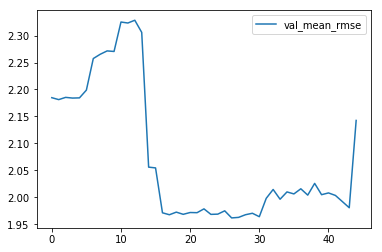

In [52]:
stats_df.plot( y='val_mean_rmse')

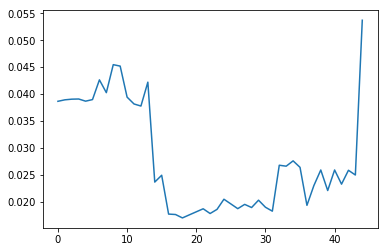

In [53]:
stats_df.val_var_rmse.plot()

##### First simple way to make validation 

In [56]:
# valid_index = full_train[full_train.fullVisitorId.isin(validationIds)].index

In [57]:
# train_index = full_train[~full_train.fullVisitorId.isin(validationIds)].index

In [58]:
# def split_vals_array(a, train_index, val_index):
#     return a[train_index].copy(), a[val_index].copy()

# def split_vals_df(a, train_index, val_index):
#     return a.iloc[train_index].copy(), a.iloc[val_index].copy()


# raw_train, raw_valid = split_vals_df(full_train, train_index, valid_index)
# X_train, X_valid = split_vals_df(df, train_index, valid_index)
# y_train, y_valid = split_vals_array(y, train_index, valid_index)

# X_train.shape, y_train.shape, X_valid.shape

((681849, 321), (681849,), (221804, 321))

In [59]:
# y_train.mean(), y_valid.mean()

(0.20146147902692166, 0.3059895624328279)

In [60]:
# y_train.max(), y_valid.max()

(23.497337833653027, 23.86437469605166)

#### CV and test

In [21]:
trn_sample_sz = 100000
# trn_sample_sz = len(full_train)

tst_sample_sz = 100000
# tst_sample_sz = len(test_df)

N_SPLITS = 5
tscv = TimeSeriesSplit(n_splits=N_SPLITS)

In [22]:
def rmse(x, y):
    return math.sqrt(((x-y)**2).mean())

In [23]:
def print_score(m, X_train, y_train, X_valid, y_valid):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
           m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'):
        res.append(m.oob_score_)
    print(res)
    return res

In [24]:
def cat_feature_ids(df, min_cat):
    return [i for i, c in enumerate(df.columns) 
            if df[c].dtype.name == 'category' and df[c].nunique() > min_cat]

In [25]:
def my_proc_fn(df, y_fld, skip_flds):
    
    skip = skip_flds.copy()
    if y_fld:
        y = df[y_fld].copy()
        skip.append(y_fld)
    
    X = df.drop(columns=skip).copy()
    
    for c in X.columns:
        if X[c].dtype.name == 'category':
            X[c] = X[c].cat.codes
            
    if y_fld:
        return X, y
    else:
        return X
    

##### Freq encoding

In [44]:
def frq_encoding(df, col):
    freq_encoding  = df.groupby(col).size() / df.shape[0]
    freq_encoding = freq_encoding.reset_index().rename(columns={0:f'{col}_frequency'})
    return df.merge(freq_encoding, on=col, how='left')

In [53]:
def encode_catrgorical(df):
    for c in df.columns:
        if df[c].dtype.name == 'category':
            df = frq_encoding(df, c)
    return df

#####  Building lgbm workflow

In [82]:
stats_cols = ['experiment'] + [f'val_rmse_{i}' for i in range(N_SPLITS)] +\
             ['val_mean_rmse', 'val_var_rmse', 'best_iter', 'submission_fname']

stats_dict = {name:[] for name in stats_cols}

In [83]:
# TODO: add column names you want to use for experiment here
# columns_to_use = ['visitStartTime', 'fullVisitorId', 'totals_transactionRevenue']

In [84]:
full_train_smpl = full_train.iloc[:trn_sample_sz].copy()
test_smpl = test_df.iloc[:tst_sample_sz].copy()

In [85]:
full_train_smpl = encode_catrgorical(full_train_smpl)

In [86]:
max_depth = 6

In [87]:
lgb_params = {'learning_rate':0.1,
             'max_depth':max_depth,
             'num_leaves':2**(max_depth - 1)}

In [88]:
lgb_params = {'learning_rate':0.1}

In [89]:
# This pipeline is for testing selected features on test set

stats_dict['experiment'].append(f"LGB+freq, params: {lgb_params}, smpl: {trn_sample_sz}")

# TODO!!! should change fname according to experiment
submission_fname = "no_submission"
stats_dict['submission_fname'].append(submission_fname)

In [90]:
def train_valid_test(model_params, cat_indices, is_test=False):
    """
    Base function for validation and test
    purposes. Should be updated to be more
    flexible.
    TODO: add param dict for model
    """

    if is_test:
        test_preds = np.zeros(len(test_smpl))

    # create array to collect metrics for every new data sample
    metrics = np.zeros((N_SPLITS, 2))

    for i, (tr_index, val_index) in enumerate(tscv.split(full_train_smpl.visitStartTime)):
        

        logger.debug(f'Process train split on fold {i}{LN_SPLITTER}')
        X_train, y_train, nans = proc_df(df=full_train_smpl.iloc[tr_index],
                                         y_fld='totals_transactionRevenue',
                                         skip_flds=['fullVisitorId', 'visitStartTime'],
                                         max_n_cat=None)

        logger.debug(f'Process valid split on fold {i}{LN_SPLITTER}')
        X_valid, y_valid, _ = proc_df(df=full_train_smpl.iloc[val_index],
                                      y_fld='totals_transactionRevenue',
                                      skip_flds=['fullVisitorId', 'visitStartTime'],
                                      max_n_cat=None, na_dict=nans)
        if is_test:
            if i == 0:
                logger.debug(f'Process test_set on fold {i}{LN_SPLITTER}')
                X_test, _, _ = proc_df(df=test_smpl, y_fld=None,
                                       skip_flds=['fullVisitorId', 'visitStartTime'],
                                       max_n_cat=None, na_dict=nans)

                print('Sanity check for column names and types for train and test')
                print(f'{check_columns_and_types_same_in(X_train, X_test)}')

        if i == 0:
            logger.debug(f'Number of features used: {len(X_train.columns)}')
            print('Sanity check for column names and types for train and valid')
            print(f'{check_columns_and_types_same_in(X_train, X_valid)}')

        # log(y) for training the model IMPORTANT!!!
        y_train, y_valid = np.log1p(y_train), np.log1p(y_valid)

        # train model
        m = lgb.LGBMRegressor(n_estimators=10000, **model_params)
        if i == 0:
            print(m)

        m.fit(X_train, y_train, eval_metric='rmse',
              early_stopping_rounds=200,
              categorical_feature=cat_indices,
              eval_set=[(X_valid, y_valid),
                        (X_train, y_train)],
              eval_names=['valid', 'train'], verbose=100)

        # Record the best iteration
        best_iteration = m.best_iteration_
        stats_dict['best_iter'] = best_iteration

        metrics[i] = [m.best_score_['train']
                      ['rmse'], m.best_score_['valid']['rmse']]
        stats_dict[f'val_rmse_{i}'].append(metrics[i, 1])

        if is_test:
            logger.debug(f'Predicting test on iteration: {i}{LN_SPLITTER}')
            y_hat = m.predict(X_test, num_iteration=best_iteration)
            y_hat[y_hat < 0] = 0
            test_preds += y_hat / N_SPLITS

    stats_dict['val_mean_rmse'].append(metrics[:, 1].mean())
    stats_dict['val_var_rmse'].append(metrics[:, 1].var())

    if is_test:
        return test_preds

In [91]:
test_preds = train_valid_test(lgb_params, cat_indices='auto', is_test=False)

2018-10-10 18:55:07,797 - new - DEBUG - Process train split on fold 0
====

2018-10-10 18:55:07,913 - new - DEBUG - Process valid split on fold 0
====

2018-10-10 18:55:08,018 - new - DEBUG - Number of features used: 77
Sanity check for column names and types for train and valid
(True, True)
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.79737	train's l2: 0.6358	valid's rmse: 2.07231	valid's l2: 4.29446
[200]	train's rmse: 0.614421	train's l2: 0.377514	valid's rmse: 2.10185	valid's l2: 4.41778
Early stopping, best iteration is:
[41]	tra

In [92]:
stats_df = pd.DataFrame(stats_dict)
os.makedirs('../log', exist_ok=True)

In [93]:
stats_df

,experiment,val_rmse_0,val_rmse_1,val_rmse_2,val_rmse_3,val_rmse_4,val_mean_rmse,val_var_rmse,best_iter,submission_fname
0,"LGB+freq, params: {'learning_rate': 0.1}, smpl...",2.034909,1.986182,1.96896,1.69972,1.690288,1.876012,0.022319,43,no_submission


In [94]:
# it's ONLY for the first time
# stats_df.to_csv('../log/lgb_experiments.csv', index=False, header=True)

In [95]:
# this for the rest of experiments
with open('../log/lgb_experiments.csv', mode='a') as fin:
    stats_df.to_csv(fin, index=False, header=False)

In [96]:
stats_df = pd.read_csv('../log/lgb_experiments.csv')

In [97]:
stats_df

,experiment,val_rmse_0,val_rmse_1,val_rmse_2,val_rmse_3,val_rmse_4,val_mean_rmse,val_var_rmse,best_iter,submission_fname
0,"LGB, params: {}, smpl: 100000",2.025238,1.982883,1.968489,1.700631,1.687969,1.873042,0.021663,35,no_submission
1,"LGB, params: {}, smpl: 903653",1.376993,1.682095,1.560613,1.740512,1.685184,1.609080,0.016922,94,lgb_default.csv
2,"LGB, params: {'learning_rate': 0.05}, smpl: 10...",2.035140,1.988831,1.962878,1.694892,1.682653,1.872879,0.023148,78,no_submission
3,"LGB+Nans params: {'learning_rate': 0.1}, smpl:...",2.027873,1.983381,1.964140,1.700631,1.689582,1.873121,0.021566,39,no_submission
4,"LGB+Nans params: {'learning_rate': 0.1, 'baggi...",2.051981,2.012089,1.980790,1.710983,1.677076,1.886584,0.025342,46,no_submission
5,"LGB+Nans params: {'learning_rate': 0.1, 'baggi...",2.047129,2.019600,1.978597,1.704850,1.676447,1.885325,0.025822,49,no_submission
6,"LGB+Nans params: {'learning_rate': 0.1, 'max_d...",2.026527,1.981429,1.970780,1.703080,1.690389,1.874441,0.021420,47,no_submission
7,"LGB+freq, params: {'learning_rate': 0.1}, smpl...",2.034909,1.986182,1.968960,1.699720,1.690288,1.876012,0.022319,43,no_submission


In [73]:
stats_df[stats_df.val_mean_rmse < 1.733256].experiment.tolist()

[]

In [39]:
# Sanity check for test prediction: should be around 0.20-0.30
test_preds.mean()

0.15880605572238402

####  Test flow

In [40]:
test_grouped = test_df[['fullVisitorId']].copy()
test_grouped['y_hat'] = np.expm1(test_preds)

In [41]:
test_grouped = test_grouped.groupby('fullVisitorId', as_index=False).sum()
test_grouped['y_hat'] = np.log1p(test_grouped['y_hat'])

In [42]:
test_grouped.y_hat.mean()

0.167369569616199

In [43]:
submit = pd.read_csv('../data/sample_submission.csv')

In [44]:
test_grouped.fullVisitorId.tolist() == submit.fullVisitorId.tolist()

True

In [45]:
submit['fullVisitorId'] = test_grouped['fullVisitorId']

In [46]:
submit['PredictedLogRevenue'] = test_grouped['y_hat']

In [47]:
os.makedirs('../submissions', exist_ok=True)

In [48]:
submit.to_csv(f'../submissions/{submission_fname}', header=True, index=False)